Using CNNs to Predict the Output of Chemical Simulation under Uncertainty

In [18]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.stats import norm
from tqdm import tqdm
from base import TrainingConfig, BaseModel, CNNConfig, CNNConfig
from models import *
from Bioprocess_Sim import *
from CSTR_Sim import *
from utils import *
from tqdm.notebook import tqdm
np.random.seed(42)

#### Create the Simulation Environment - for a CSTR

3 State Variables:
$$
C_A, \, T, \, \text{Concentration of A, Temperature and Setpoint}, C_{As}
$$

2 Manipulated Variables:
$$
T_i, \, C_{Af} \, \text{Inlet Temperature and Feed Concentration}
$$

Disturbance: 
$$
T_C, \text{ - coolant temperature}
$$

The Simulation randomly generates actions, setpoints and disturbances across the length of the simulation, with the aim of the data driven model being to learn the relationships between variables to predict the temporal value of the state variables (exc setpoint) within a confidence interval

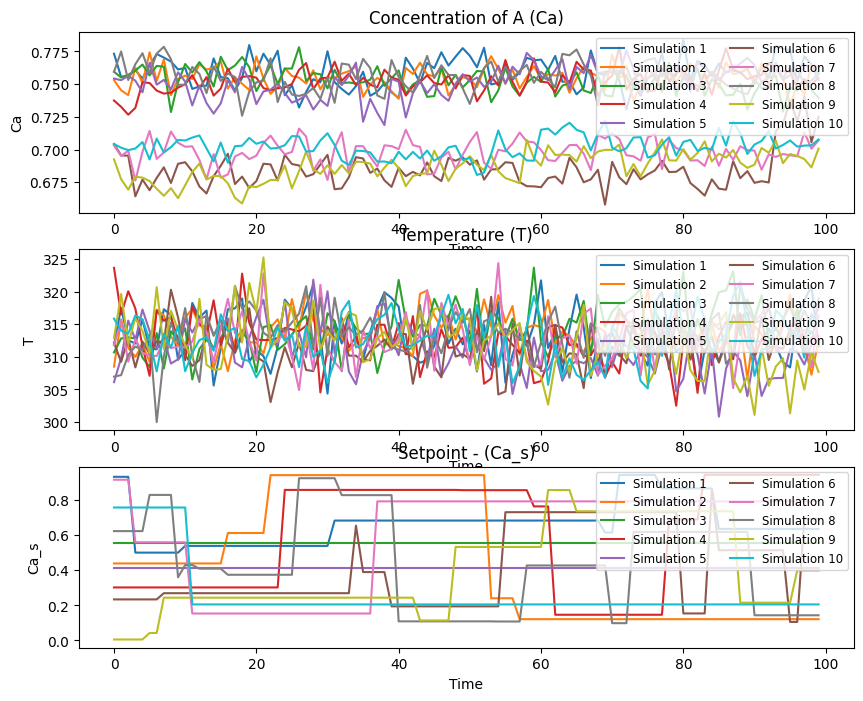

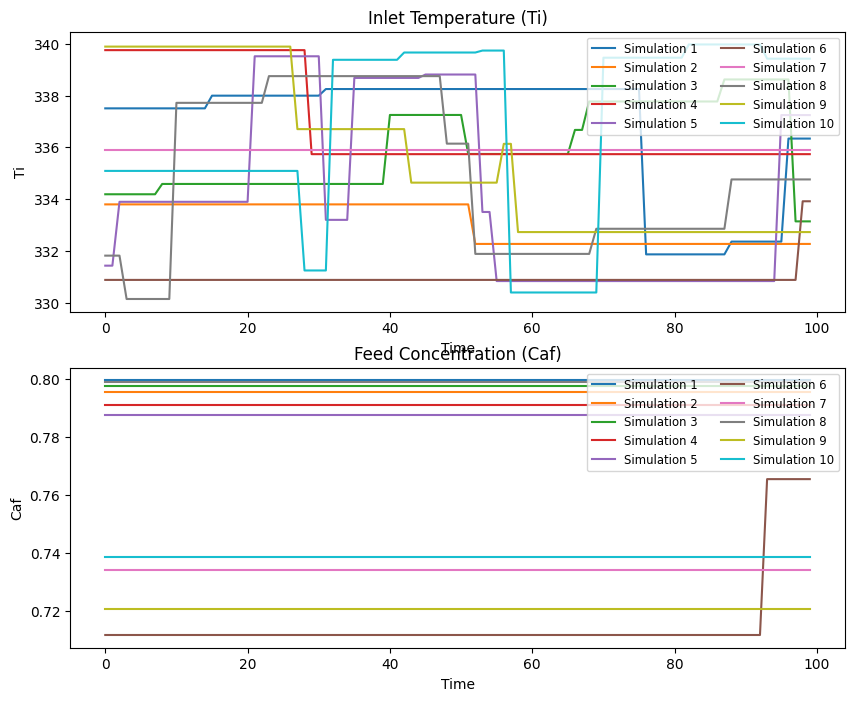

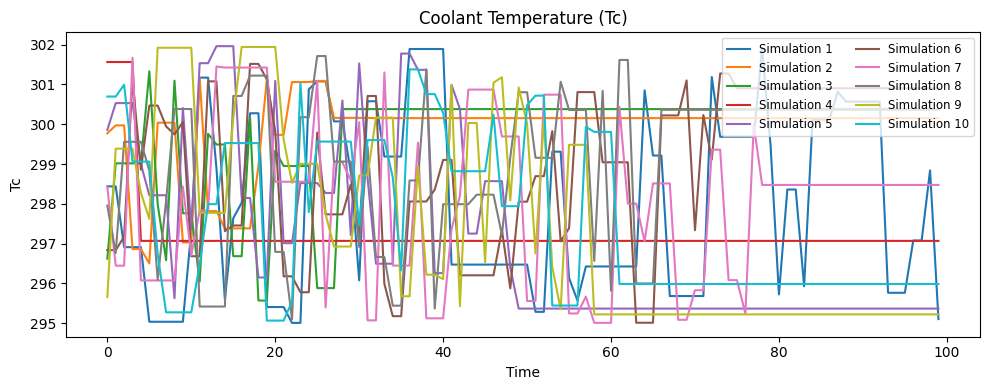

In [19]:
CSTR_Config = SimulationConfig(n_simulations=10, T = 101, tsim = 500) # Simulate the CSTR 10 times, with 5000 timesteps over 1000 second period

simulator = CSTRSimulator(CSTR_Config)
simulation_results = simulator.run_multiple_simulations()

# Plot the output of the Simulation
simulator.plot_results(simulation_results)

Then process the simulation output into data to be fed into the data driven model. First define a training configuration.

The data is processed into sequences with a lookback window and a prediction horizon of shape (time_step, lookback_window, no_features).

The data is then scaled using a MinMaxScaler, and split into a sequential train test set with the first 80% of the datapoints being included in the train set.


In [20]:
converter = CSTRConverter()
features, targets = converter.convert(simulation_results)

# Define a preliminary training configuration for the model
# Data processing uses an initial lookback region of 5 timesteps to predict 1 in the future 
# with an 80% train test split and a batch size of 4
training_config = TrainingConfig(
    batch_size = 4,
    num_epochs = 50,
    learning_rate = 0.001,
    time_step = 5,
    horizon = 1,
    weight_decay = 0.01,
    factor = 0.8,
    patience = 10,
    delta = 0.1,
    train_test_split = 0.8,
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
)

data_processor = DataProcessor(training_config)
(train_loader, test_loader, X_train, X_test, y_train, y_test) = data_processor.prepare_data(features, targets)

Can then train an initial model, in this example use a unidirectional point prediction CNN, defining the configuration for the model.

In [21]:
CNN_Config = CNNConfig(
    conv_channels = [16, 32],
    kernel_sizes = [5, 3],
    fc_dims = [101, 128],
    dropout = 0.1
    )

model = StandardCNN(
    config = CNN_Config,
    input_dim = X_train.shape[2],
    output_dim = y_train.shape[1],
)

# Train the model
criterion = nn.MSELoss()
trainer = ModelTrainer(model, training_config)
model, history, avg_loss = trainer.train(train_loader, test_loader, criterion)

Epoch [10/50], Train Loss: 0.0412, Test Loss: 0.0424, Avg Loss: 0.0418
Epoch [20/50], Train Loss: 0.0391, Test Loss: 0.0448, Avg Loss: 0.0419
Epoch [30/50], Train Loss: 0.0387, Test Loss: 0.0408, Avg Loss: 0.0398
Epoch [40/50], Train Loss: 0.0390, Test Loss: 0.0413, Avg Loss: 0.0402
Epoch [50/50], Train Loss: 0.0401, Test Loss: 0.0422, Avg Loss: 0.0412


Evaluate the model and inverse transform the data to plot and visualise the model predictions against the ground truth.

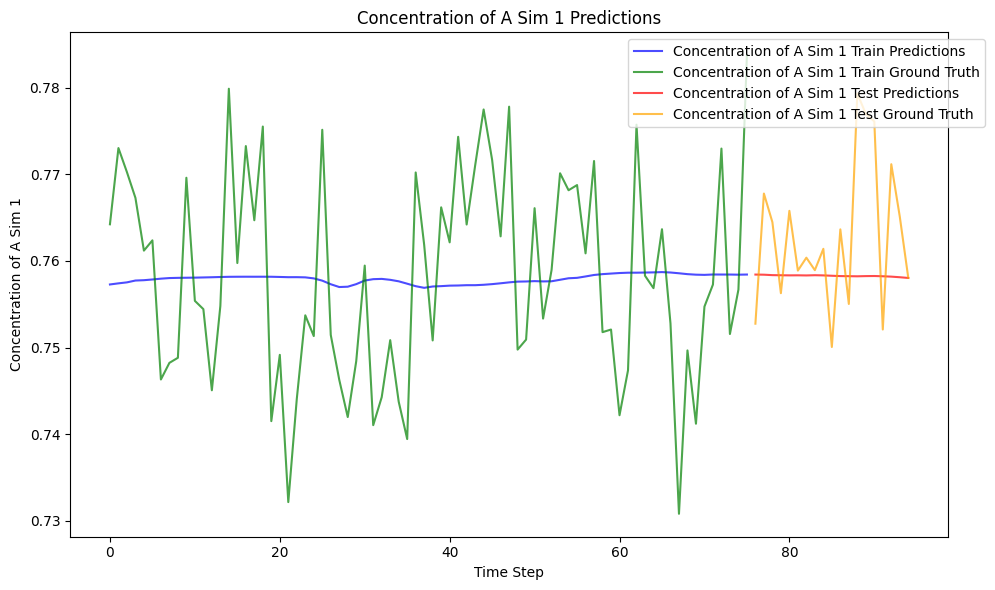

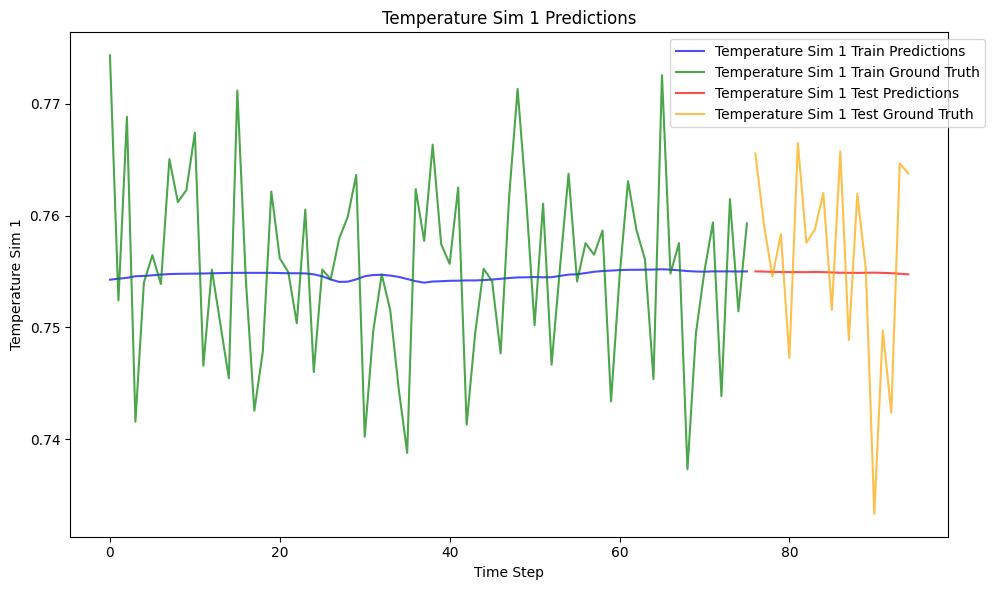

In [22]:
# Find the model predictions
model.eval()
with torch.no_grad():
    train_pred = model(X_train.to(training_config.device)).cpu().numpy()
    test_pred = model(X_test.to(training_config.device)).cpu().numpy()

# Transform the predictions back to the original
scaler = data_processor.target_scaler
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

# Invert the ground truth data
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)


# Plot the results of the model
feature_names = ['Concentration of A', 'Temperature']
visualiser = Visualizer()
# For simplicity we will plot the first simulation
visualiser.plot_predictions(train_pred, test_pred, y_train, y_test, feature_names, num_simulations=1)
    

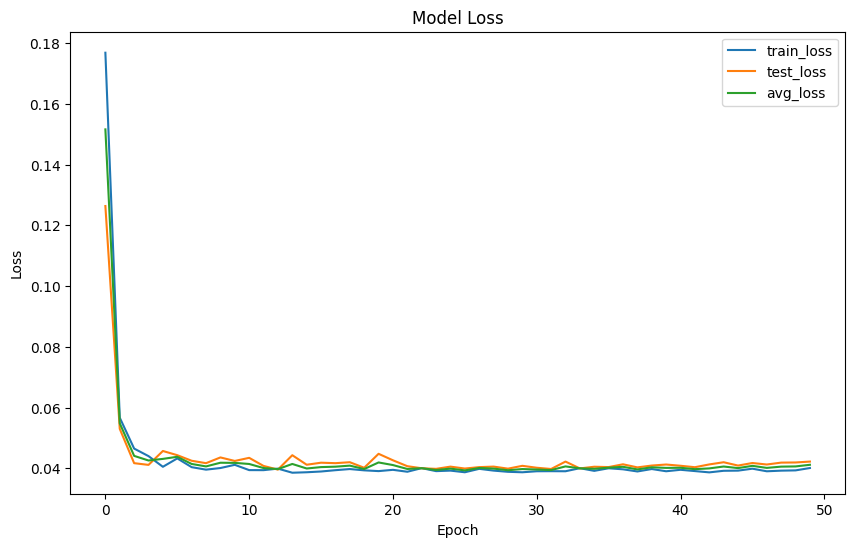

In [23]:
# Plot the loss of the model
visualiser.plot_loss(history)

Can use Bayesian Optimisation to find the best hyperparameters for the model

In [24]:
# First set the bounds for CNN Model
CNN_ConfigBounds = {
# Training config bounds
'batch_size': (2, 50) if isinstance(simulator, CSTRSimulator) else (2, 10),
'num_epochs': (50, 500),
'learning_rate': (0.0001, 0.1),
'time_step': (2, 50) if isinstance(simulator, CSTRSimulator) else (2, 10),
'horizon': (1, 10),
'weight_decay': (1e-6, 0.1),
'factor': (0.1, 0.99),
'patience': (5, 100),
'delta': (1e-6, 0.1),      

# CNN specific bounds - much wider ranges
'conv_channels': [(8, 128), (16, 256)],  # Much wider range for channel sizes
'kernel_sizes': [(2, 9), (2, 7)],       # More kernel size options
'fc_dims': [(32, 512), (64, 1024)],     # Wider range for fully connected layers
'dropout': (0.0, 0.9)                    # Full range of dropout values
}

# Call the optimiser
optimiser = ModelOptimisation(model_class=StandardCNN, sim_config=CSTR_Config,
                              train_config=training_config, model_config=CNN_Config,
                              config_bounds=CNN_ConfigBounds, simulator=CSTRSimulator,
                              converter=CSTRConverter, data_processor=DataProcessor,
                              trainer_class=ModelTrainer, iters=20)

best_params, best_loss = optimiser.optimise()
# The best performing model is saved automatically by the optimiser and can be loaded
cp = torch.load('best_model.pth')
model = StandardCNN(cp['model_config'],
                     input_dim=X_train.shape[2],
                     output_dim=y_train.shape[1],
                     )
model.load_state_dict(cp['model_state_dict'])

Epoch [10/228], Train Loss: 0.0634, Test Loss: 0.0512, Avg Loss: 0.0573
Epoch [20/228], Train Loss: 0.0699, Test Loss: 0.0738, Avg Loss: 0.0719
Epoch [30/228], Train Loss: 0.0760, Test Loss: 0.0806, Avg Loss: 0.0783
Epoch [40/228], Train Loss: 0.0850, Test Loss: 0.0890, Avg Loss: 0.0870
Epoch [50/228], Train Loss: 0.0834, Test Loss: 0.0915, Avg Loss: 0.0875
Epoch [60/228], Train Loss: 0.0798, Test Loss: 0.0850, Avg Loss: 0.0824
Epoch [70/228], Train Loss: 0.0767, Test Loss: 0.0811, Avg Loss: 0.0789
Epoch [80/228], Train Loss: 0.0820, Test Loss: 0.0895, Avg Loss: 0.0858
Epoch [90/228], Train Loss: 0.0750, Test Loss: 0.0820, Avg Loss: 0.0785
Epoch [100/228], Train Loss: 0.0813, Test Loss: 0.0888, Avg Loss: 0.0850
Epoch [110/228], Train Loss: 0.0727, Test Loss: 0.0811, Avg Loss: 0.0769
Epoch [120/228], Train Loss: 0.0834, Test Loss: 0.0842, Avg Loss: 0.0838
Epoch [130/228], Train Loss: 0.0834, Test Loss: 0.0891, Avg Loss: 0.0863
Epoch [140/228], Train Loss: 0.0833, Test Loss: 0.0841, Avg 

Optimisation Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [10/355], Train Loss: 0.0685, Test Loss: 0.0681, Avg Loss: 0.0683
Epoch [20/355], Train Loss: 0.0670, Test Loss: 0.0616, Avg Loss: 0.0643
Epoch [30/355], Train Loss: 0.0734, Test Loss: 0.0642, Avg Loss: 0.0688
Epoch [40/355], Train Loss: 0.0736, Test Loss: 0.0634, Avg Loss: 0.0685
Epoch [50/355], Train Loss: 0.0757, Test Loss: 0.0677, Avg Loss: 0.0717
Epoch [60/355], Train Loss: 0.0753, Test Loss: 0.0644, Avg Loss: 0.0698
Epoch [70/355], Train Loss: 0.0747, Test Loss: 0.0592, Avg Loss: 0.0670
Epoch [80/355], Train Loss: 0.0617, Test Loss: 0.0600, Avg Loss: 0.0608
Epoch [90/355], Train Loss: 0.0636, Test Loss: 0.0620, Avg Loss: 0.0628
Epoch [100/355], Train Loss: 0.0632, Test Loss: 0.0608, Avg Loss: 0.0620
Epoch [110/355], Train Loss: 0.0653, Test Loss: 0.0578, Avg Loss: 0.0616
Epoch [120/355], Train Loss: 0.0625, Test Loss: 0.0600, Avg Loss: 0.0612
Epoch [130/355], Train Loss: 0.0619, Test Loss: 0.0602, Avg Loss: 0.0610
Epoch [140/355], Train Loss: 0.0614, Test Loss: 0.0578, Avg 

Optimisation Progress:   5%|▌         | 1/20 [00:14<04:41, 14.79s/it, Loss=0.0574]

Epoch [10/141], Train Loss: 4.2102, Test Loss: 0.0841, Avg Loss: 2.1472
Epoch [20/141], Train Loss: 0.1213, Test Loss: 0.0649, Avg Loss: 0.0931
Epoch [30/141], Train Loss: 0.0737, Test Loss: 0.0666, Avg Loss: 0.0701
Epoch [40/141], Train Loss: 0.0668, Test Loss: 0.0743, Avg Loss: 0.0706
Epoch [50/141], Train Loss: 0.0742, Test Loss: 0.0769, Avg Loss: 0.0756
Epoch [60/141], Train Loss: 0.0671, Test Loss: 0.0727, Avg Loss: 0.0699
Epoch [70/141], Train Loss: 0.0681, Test Loss: 0.0709, Avg Loss: 0.0695
Epoch [80/141], Train Loss: 0.0663, Test Loss: 0.0752, Avg Loss: 0.0707
Epoch [90/141], Train Loss: 0.0729, Test Loss: 0.0804, Avg Loss: 0.0766
Epoch [100/141], Train Loss: 0.0635, Test Loss: 0.0736, Avg Loss: 0.0685
Epoch [110/141], Train Loss: 0.0658, Test Loss: 0.0730, Avg Loss: 0.0694
Epoch [120/141], Train Loss: 0.0647, Test Loss: 0.0730, Avg Loss: 0.0688
Epoch [130/141], Train Loss: 0.0659, Test Loss: 0.0734, Avg Loss: 0.0696


Optimisation Progress:  10%|█         | 2/20 [00:18<02:33,  8.51s/it, Loss=0.0574]

Epoch [140/141], Train Loss: 0.0620, Test Loss: 0.0722, Avg Loss: 0.0671
Epoch [10/439], Train Loss: 0.0648, Test Loss: 0.1197, Avg Loss: 0.0922
Epoch [20/439], Train Loss: 0.0539, Test Loss: 0.1039, Avg Loss: 0.0789
Epoch [30/439], Train Loss: 0.0489, Test Loss: 0.1045, Avg Loss: 0.0767
Epoch [40/439], Train Loss: 0.0525, Test Loss: 0.1004, Avg Loss: 0.0764
Epoch [50/439], Train Loss: 0.0494, Test Loss: 0.0940, Avg Loss: 0.0717
Epoch [60/439], Train Loss: 0.0499, Test Loss: 0.0638, Avg Loss: 0.0569
Epoch [70/439], Train Loss: 0.0470, Test Loss: 0.0715, Avg Loss: 0.0592
Epoch [80/439], Train Loss: 0.0493, Test Loss: 0.1499, Avg Loss: 0.0996
Epoch [90/439], Train Loss: 0.0440, Test Loss: 0.1377, Avg Loss: 0.0909
Epoch [100/439], Train Loss: 0.0487, Test Loss: 0.1348, Avg Loss: 0.0918
Epoch [110/439], Train Loss: 0.0483, Test Loss: 0.1447, Avg Loss: 0.0965
Epoch [120/439], Train Loss: 0.0426, Test Loss: 0.2416, Avg Loss: 0.1421
Epoch [130/439], Train Loss: 0.0457, Test Loss: 0.2767, Avg 

Optimisation Progress:  15%|█▌        | 3/20 [00:23<01:56,  6.88s/it, Loss=0.0574]

Epoch [140/439], Train Loss: 0.0494, Test Loss: 0.0669, Avg Loss: 0.0581
Early Stopping
Epoch [10/447], Train Loss: 0.0485, Test Loss: 0.0370, Avg Loss: 0.0428
Epoch [20/447], Train Loss: 0.0467, Test Loss: 0.0377, Avg Loss: 0.0422
Epoch [30/447], Train Loss: 0.0529, Test Loss: 0.0418, Avg Loss: 0.0474
Epoch [40/447], Train Loss: 0.0473, Test Loss: 0.0388, Avg Loss: 0.0431
Epoch [50/447], Train Loss: 0.0486, Test Loss: 0.0408, Avg Loss: 0.0447
Epoch [60/447], Train Loss: 0.0514, Test Loss: 0.0446, Avg Loss: 0.0480
Epoch [70/447], Train Loss: 0.0476, Test Loss: 0.0417, Avg Loss: 0.0447
Epoch [80/447], Train Loss: 0.0466, Test Loss: 0.0409, Avg Loss: 0.0438
Epoch [90/447], Train Loss: 0.0460, Test Loss: 0.0403, Avg Loss: 0.0432
Epoch [100/447], Train Loss: 0.0487, Test Loss: 0.0412, Avg Loss: 0.0450
Epoch [110/447], Train Loss: 0.0570, Test Loss: 0.0432, Avg Loss: 0.0501
Epoch [120/447], Train Loss: 0.0474, Test Loss: 0.0399, Avg Loss: 0.0436
Epoch [130/447], Train Loss: 0.0458, Test Los

Optimisation Progress:  20%|██        | 4/20 [00:28<01:35,  5.97s/it, Loss=0.0436]

Epoch [10/122], Train Loss: 0.4101, Test Loss: 12226.2070, Avg Loss: 6113.3085
Epoch [20/122], Train Loss: 0.0617, Test Loss: 0.0484, Avg Loss: 0.0550
Epoch [30/122], Train Loss: 0.0374, Test Loss: 0.0494, Avg Loss: 0.0434
Epoch [40/122], Train Loss: 0.0473, Test Loss: 0.0487, Avg Loss: 0.0480
Epoch [50/122], Train Loss: 0.0397, Test Loss: 0.0459, Avg Loss: 0.0428
Epoch [60/122], Train Loss: 0.0346, Test Loss: 0.0487, Avg Loss: 0.0416
Epoch [70/122], Train Loss: 0.0390, Test Loss: 0.0477, Avg Loss: 0.0433
Epoch [80/122], Train Loss: 0.0356, Test Loss: 0.0509, Avg Loss: 0.0433
Epoch [90/122], Train Loss: 0.0398, Test Loss: 0.0483, Avg Loss: 0.0441
Epoch [100/122], Train Loss: 0.0374, Test Loss: 0.0502, Avg Loss: 0.0438
Epoch [110/122], Train Loss: 0.0354, Test Loss: 0.0470, Avg Loss: 0.0412


Optimisation Progress:  25%|██▌       | 5/20 [00:32<01:17,  5.16s/it, Loss=0.043] 

Epoch [120/122], Train Loss: 0.0400, Test Loss: 0.0442, Avg Loss: 0.0421
Epoch [10/357], Train Loss: 0.0766, Test Loss: 0.0783, Avg Loss: 0.0774
Epoch [20/357], Train Loss: 0.0851, Test Loss: 0.0758, Avg Loss: 0.0805
Epoch [30/357], Train Loss: 0.0866, Test Loss: 0.0797, Avg Loss: 0.0832
Epoch [40/357], Train Loss: 0.0876, Test Loss: 0.0757, Avg Loss: 0.0817
Epoch [50/357], Train Loss: 0.0861, Test Loss: 0.0768, Avg Loss: 0.0815
Epoch [60/357], Train Loss: 0.0856, Test Loss: 0.0781, Avg Loss: 0.0819
Epoch [70/357], Train Loss: 0.0875, Test Loss: 0.0783, Avg Loss: 0.0829
Epoch [80/357], Train Loss: 0.0849, Test Loss: 0.0763, Avg Loss: 0.0806
Epoch [90/357], Train Loss: 0.0892, Test Loss: 0.0769, Avg Loss: 0.0831
Epoch [100/357], Train Loss: 0.0924, Test Loss: 0.0796, Avg Loss: 0.0860
Epoch [110/357], Train Loss: 0.0895, Test Loss: 0.0789, Avg Loss: 0.0842
Epoch [120/357], Train Loss: 0.0920, Test Loss: 0.0814, Avg Loss: 0.0867
Epoch [130/357], Train Loss: 0.0933, Test Loss: 0.0807, Avg 

Optimisation Progress:  30%|███       | 6/20 [00:41<01:33,  6.66s/it, Loss=0.043]

Epoch [350/357], Train Loss: 0.0906, Test Loss: 0.0788, Avg Loss: 0.0847
Epoch [10/428], Train Loss: 0.0551, Test Loss: 0.0680, Avg Loss: 0.0616
Epoch [20/428], Train Loss: 0.0618, Test Loss: 0.0621, Avg Loss: 0.0620
Epoch [30/428], Train Loss: 0.0650, Test Loss: 0.0628, Avg Loss: 0.0639
Epoch [40/428], Train Loss: 0.0666, Test Loss: 0.0633, Avg Loss: 0.0649
Epoch [50/428], Train Loss: 0.0649, Test Loss: 0.0627, Avg Loss: 0.0638
Epoch [60/428], Train Loss: 0.0692, Test Loss: 0.0632, Avg Loss: 0.0662
Epoch [70/428], Train Loss: 0.0673, Test Loss: 0.0642, Avg Loss: 0.0657
Epoch [80/428], Train Loss: 0.0669, Test Loss: 0.0635, Avg Loss: 0.0652
Epoch [90/428], Train Loss: 0.0681, Test Loss: 0.0649, Avg Loss: 0.0665
Epoch [100/428], Train Loss: 0.0679, Test Loss: 0.0654, Avg Loss: 0.0667
Epoch [110/428], Train Loss: 0.0669, Test Loss: 0.0642, Avg Loss: 0.0656
Epoch [120/428], Train Loss: 0.0696, Test Loss: 0.0638, Avg Loss: 0.0667
Epoch [130/428], Train Loss: 0.0689, Test Loss: 0.0635, Avg 

Optimisation Progress:  35%|███▌      | 7/20 [00:57<02:05,  9.68s/it, Loss=0.043]

Epoch [10/461], Train Loss: 0.3006, Test Loss: 0.3574, Avg Loss: 0.3290
Epoch [20/461], Train Loss: 0.2018, Test Loss: 0.0665, Avg Loss: 0.1342
Epoch [30/461], Train Loss: 0.0485, Test Loss: 0.0462, Avg Loss: 0.0473
Epoch [40/461], Train Loss: 0.0502, Test Loss: 0.0458, Avg Loss: 0.0480
Epoch [50/461], Train Loss: 0.0519, Test Loss: 0.0447, Avg Loss: 0.0483
Epoch [60/461], Train Loss: 0.0490, Test Loss: 0.0452, Avg Loss: 0.0471
Epoch [70/461], Train Loss: 0.0514, Test Loss: 0.0439, Avg Loss: 0.0477
Epoch [80/461], Train Loss: 0.0495, Test Loss: 0.0449, Avg Loss: 0.0472
Epoch [90/461], Train Loss: 0.0468, Test Loss: 0.0452, Avg Loss: 0.0460
Epoch [100/461], Train Loss: 0.0542, Test Loss: 0.0439, Avg Loss: 0.0490
Epoch [110/461], Train Loss: 0.0464, Test Loss: 0.0434, Avg Loss: 0.0449
Epoch [120/461], Train Loss: 0.0481, Test Loss: 0.0442, Avg Loss: 0.0462
Epoch [130/461], Train Loss: 0.0467, Test Loss: 0.0436, Avg Loss: 0.0452
Epoch [140/461], Train Loss: 0.0478, Test Loss: 0.0434, Avg 

Optimisation Progress:  40%|████      | 8/20 [01:12<02:15, 11.30s/it, Loss=0.043]

Epoch [460/461], Train Loss: 0.0505, Test Loss: 0.0427, Avg Loss: 0.0466
Epoch [10/361], Train Loss: 0.0524, Test Loss: 0.0715, Avg Loss: 0.0620
Epoch [20/361], Train Loss: 0.0424, Test Loss: 0.0600, Avg Loss: 0.0512
Epoch [30/361], Train Loss: 0.0464, Test Loss: 0.0633, Avg Loss: 0.0548
Epoch [40/361], Train Loss: 0.0423, Test Loss: 0.0516, Avg Loss: 0.0470
Epoch [50/361], Train Loss: 0.0436, Test Loss: 0.0574, Avg Loss: 0.0505
Epoch [60/361], Train Loss: 0.0367, Test Loss: 0.0553, Avg Loss: 0.0460
Epoch [70/361], Train Loss: 0.0381, Test Loss: 0.1824, Avg Loss: 0.1103
Epoch [80/361], Train Loss: 0.0394, Test Loss: 0.0571, Avg Loss: 0.0482
Epoch [90/361], Train Loss: 0.0421, Test Loss: 0.0522, Avg Loss: 0.0471
Epoch [100/361], Train Loss: 0.0446, Test Loss: 0.0576, Avg Loss: 0.0511
Epoch [110/361], Train Loss: 0.0425, Test Loss: 0.0532, Avg Loss: 0.0479
Epoch [120/361], Train Loss: 0.0416, Test Loss: 0.0553, Avg Loss: 0.0484
Epoch [130/361], Train Loss: 0.0442, Test Loss: 0.0553, Avg 

Optimisation Progress:  45%|████▌     | 9/20 [01:18<01:47,  9.79s/it, Loss=0.043]

Epoch [350/361], Train Loss: 0.0420, Test Loss: 0.0532, Avg Loss: 0.0476
Epoch [360/361], Train Loss: 0.0399, Test Loss: 0.0533, Avg Loss: 0.0466
Epoch [10/66], Train Loss: 0.0512, Test Loss: 0.0940, Avg Loss: 0.0726
Epoch [20/66], Train Loss: 0.0434, Test Loss: 0.0978, Avg Loss: 0.0706
Epoch [30/66], Train Loss: 0.0433, Test Loss: 0.0486, Avg Loss: 0.0460
Epoch [40/66], Train Loss: 0.0453, Test Loss: 0.0565, Avg Loss: 0.0509
Epoch [50/66], Train Loss: 0.0515, Test Loss: 0.0431, Avg Loss: 0.0473
Epoch [60/66], Train Loss: 0.0412, Test Loss: 0.0638, Avg Loss: 0.0525


Optimisation Progress:  50%|█████     | 10/20 [01:22<01:20,  8.01s/it, Loss=0.043]

Epoch [10/422], Train Loss: 1.2206, Test Loss: 2598.6106, Avg Loss: 1299.9156
Epoch [20/422], Train Loss: 0.3063, Test Loss: 0.0881, Avg Loss: 0.1972
Epoch [30/422], Train Loss: 0.1394, Test Loss: 0.1464, Avg Loss: 0.1429
Epoch [40/422], Train Loss: 0.1088, Test Loss: 0.0873, Avg Loss: 0.0980
Epoch [50/422], Train Loss: 0.0833, Test Loss: 0.0829, Avg Loss: 0.0831
Epoch [60/422], Train Loss: 0.0761, Test Loss: 0.0910, Avg Loss: 0.0836
Epoch [70/422], Train Loss: 0.0550, Test Loss: 0.0798, Avg Loss: 0.0674
Epoch [80/422], Train Loss: 0.0524, Test Loss: 0.0849, Avg Loss: 0.0687
Epoch [90/422], Train Loss: 0.0545, Test Loss: 0.0798, Avg Loss: 0.0672
Epoch [100/422], Train Loss: 0.0514, Test Loss: 0.0760, Avg Loss: 0.0637
Epoch [110/422], Train Loss: 0.0469, Test Loss: 0.0767, Avg Loss: 0.0618
Epoch [120/422], Train Loss: 0.0492, Test Loss: 0.0760, Avg Loss: 0.0626
Epoch [130/422], Train Loss: 0.0480, Test Loss: 0.0782, Avg Loss: 0.0631
Epoch [140/422], Train Loss: 0.0455, Test Loss: 0.0765

Optimisation Progress:  55%|█████▌    | 11/20 [01:33<01:18,  8.71s/it, Loss=0.043]

Epoch [420/422], Train Loss: 0.0422, Test Loss: 0.0748, Avg Loss: 0.0585
Epoch [10/134], Train Loss: 0.0622, Test Loss: 0.1473, Avg Loss: 0.1048
Epoch [20/134], Train Loss: 0.0378, Test Loss: 0.0364, Avg Loss: 0.0371
Epoch [30/134], Train Loss: 0.0380, Test Loss: 0.0351, Avg Loss: 0.0365
Epoch [40/134], Train Loss: 0.0382, Test Loss: 0.0354, Avg Loss: 0.0368
Epoch [50/134], Train Loss: 0.0384, Test Loss: 0.0338, Avg Loss: 0.0361
Epoch [60/134], Train Loss: 0.0380, Test Loss: 0.0352, Avg Loss: 0.0366
Epoch [70/134], Train Loss: 0.0391, Test Loss: 0.0333, Avg Loss: 0.0362
Epoch [80/134], Train Loss: 0.0381, Test Loss: 0.0337, Avg Loss: 0.0359
Epoch [90/134], Train Loss: 0.0381, Test Loss: 0.0348, Avg Loss: 0.0364
Epoch [100/134], Train Loss: 0.0368, Test Loss: 0.0343, Avg Loss: 0.0356
Epoch [110/134], Train Loss: 0.0383, Test Loss: 0.0332, Avg Loss: 0.0358
Epoch [120/134], Train Loss: 0.0380, Test Loss: 0.0366, Avg Loss: 0.0373
Epoch [130/134], Train Loss: 0.0369, Test Loss: 0.0348, Avg 

Optimisation Progress:  60%|██████    | 12/20 [01:35<00:53,  6.72s/it, Loss=0.0349]

Epoch [10/430], Train Loss: 0.0510, Test Loss: 0.0607, Avg Loss: 0.0558
Epoch [20/430], Train Loss: 0.0512, Test Loss: 0.0616, Avg Loss: 0.0564
Epoch [30/430], Train Loss: 0.0541, Test Loss: 0.0621, Avg Loss: 0.0581
Epoch [40/430], Train Loss: 0.0495, Test Loss: 0.0660, Avg Loss: 0.0578
Epoch [50/430], Train Loss: 0.0580, Test Loss: 0.0676, Avg Loss: 0.0628
Epoch [60/430], Train Loss: 0.0541, Test Loss: 0.0680, Avg Loss: 0.0610
Epoch [70/430], Train Loss: 0.0577, Test Loss: 0.0643, Avg Loss: 0.0610
Epoch [80/430], Train Loss: 0.0585, Test Loss: 0.0685, Avg Loss: 0.0635
Epoch [90/430], Train Loss: 0.0583, Test Loss: 0.0713, Avg Loss: 0.0648
Epoch [100/430], Train Loss: 0.0603, Test Loss: 0.0711, Avg Loss: 0.0657
Epoch [110/430], Train Loss: 0.0622, Test Loss: 0.0714, Avg Loss: 0.0668
Epoch [120/430], Train Loss: 0.0600, Test Loss: 0.0715, Avg Loss: 0.0658
Epoch [130/430], Train Loss: 0.0601, Test Loss: 0.0705, Avg Loss: 0.0653
Epoch [140/430], Train Loss: 0.0610, Test Loss: 0.0712, Avg 

Optimisation Progress:  65%|██████▌   | 13/20 [01:48<00:59,  8.57s/it, Loss=0.0349]

Epoch [400/430], Train Loss: 0.0615, Test Loss: 0.0720, Avg Loss: 0.0668
Early Stopping
Epoch [10/312], Train Loss: 0.3828, Test Loss: 0.6770, Avg Loss: 0.5299
Epoch [20/312], Train Loss: 0.1186, Test Loss: 0.0541, Avg Loss: 0.0863
Epoch [30/312], Train Loss: 0.0440, Test Loss: 0.0351, Avg Loss: 0.0395
Epoch [40/312], Train Loss: 0.0403, Test Loss: 0.0363, Avg Loss: 0.0383
Epoch [50/312], Train Loss: 0.0373, Test Loss: 0.0349, Avg Loss: 0.0361
Epoch [60/312], Train Loss: 0.0373, Test Loss: 0.0336, Avg Loss: 0.0354
Epoch [70/312], Train Loss: 0.0367, Test Loss: 0.0377, Avg Loss: 0.0372
Epoch [80/312], Train Loss: 0.0366, Test Loss: 0.0352, Avg Loss: 0.0359
Epoch [90/312], Train Loss: 0.0392, Test Loss: 0.0335, Avg Loss: 0.0363
Epoch [100/312], Train Loss: 0.0386, Test Loss: 0.0364, Avg Loss: 0.0375
Epoch [110/312], Train Loss: 0.0368, Test Loss: 0.0326, Avg Loss: 0.0347
Epoch [120/312], Train Loss: 0.0361, Test Loss: 0.0341, Avg Loss: 0.0351
Epoch [130/312], Train Loss: 0.0367, Test Los

Optimisation Progress:  70%|███████   | 14/20 [02:00<00:57,  9.62s/it, Loss=0.0349]

Epoch [310/312], Train Loss: 0.0413, Test Loss: 0.0416, Avg Loss: 0.0415
Epoch [10/371], Train Loss: 0.0515, Test Loss: 0.0553, Avg Loss: 0.0534
Epoch [20/371], Train Loss: 0.0598, Test Loss: 0.1066, Avg Loss: 0.0832
Epoch [30/371], Train Loss: 0.0463, Test Loss: 0.0612, Avg Loss: 0.0537
Epoch [40/371], Train Loss: 0.0403, Test Loss: 0.0607, Avg Loss: 0.0505
Epoch [50/371], Train Loss: 0.0429, Test Loss: 0.0490, Avg Loss: 0.0460
Epoch [60/371], Train Loss: 0.0453, Test Loss: 0.0601, Avg Loss: 0.0527
Epoch [70/371], Train Loss: 0.0421, Test Loss: 0.0569, Avg Loss: 0.0495
Epoch [80/371], Train Loss: 0.0423, Test Loss: 0.0602, Avg Loss: 0.0513
Epoch [90/371], Train Loss: 0.0415, Test Loss: 0.0571, Avg Loss: 0.0493
Epoch [100/371], Train Loss: 0.0414, Test Loss: 0.0594, Avg Loss: 0.0504
Epoch [110/371], Train Loss: 0.0411, Test Loss: 0.0583, Avg Loss: 0.0497
Epoch [120/371], Train Loss: 0.0412, Test Loss: 0.0569, Avg Loss: 0.0490
Epoch [130/371], Train Loss: 0.0429, Test Loss: 0.0577, Avg 

Optimisation Progress:  75%|███████▌  | 15/20 [02:10<00:48,  9.69s/it, Loss=0.0349]

Epoch [10/450], Train Loss: 0.0697, Test Loss: 0.0689, Avg Loss: 0.0693
Epoch [20/450], Train Loss: 0.0735, Test Loss: 0.0737, Avg Loss: 0.0736
Epoch [30/450], Train Loss: 0.0833, Test Loss: 0.0806, Avg Loss: 0.0820
Epoch [40/450], Train Loss: 0.0817, Test Loss: 0.0798, Avg Loss: 0.0808
Epoch [50/450], Train Loss: 0.0827, Test Loss: 0.0808, Avg Loss: 0.0817
Epoch [60/450], Train Loss: 0.0827, Test Loss: 0.0811, Avg Loss: 0.0819
Epoch [70/450], Train Loss: 0.0836, Test Loss: 0.0811, Avg Loss: 0.0824
Epoch [80/450], Train Loss: 0.0831, Test Loss: 0.0812, Avg Loss: 0.0821
Epoch [90/450], Train Loss: 0.0830, Test Loss: 0.0812, Avg Loss: 0.0821
Epoch [100/450], Train Loss: 0.0839, Test Loss: 0.0812, Avg Loss: 0.0825
Epoch [110/450], Train Loss: 0.0841, Test Loss: 0.0812, Avg Loss: 0.0826
Epoch [120/450], Train Loss: 0.0834, Test Loss: 0.0812, Avg Loss: 0.0823
Epoch [130/450], Train Loss: 0.0838, Test Loss: 0.0812, Avg Loss: 0.0825


Optimisation Progress:  80%|████████  | 16/20 [02:15<00:33,  8.36s/it, Loss=0.0349]

Epoch [140/450], Train Loss: 0.0824, Test Loss: 0.0812, Avg Loss: 0.0818
Early Stopping
Epoch [10/170], Train Loss: 5.0888, Test Loss: 0.5715, Avg Loss: 2.8302
Epoch [20/170], Train Loss: 2.8880, Test Loss: 0.1308, Avg Loss: 1.5094
Epoch [30/170], Train Loss: 0.2598, Test Loss: 0.1997, Avg Loss: 0.2298
Epoch [40/170], Train Loss: 0.2701, Test Loss: 0.0616, Avg Loss: 0.1658
Epoch [50/170], Train Loss: 0.0801, Test Loss: 0.0499, Avg Loss: 0.0650
Epoch [60/170], Train Loss: 0.0482, Test Loss: 0.0566, Avg Loss: 0.0524
Epoch [70/170], Train Loss: 0.0549, Test Loss: 0.0502, Avg Loss: 0.0525
Epoch [80/170], Train Loss: 0.0491, Test Loss: 0.0533, Avg Loss: 0.0512
Epoch [90/170], Train Loss: 0.0618, Test Loss: 0.0602, Avg Loss: 0.0610
Epoch [100/170], Train Loss: 0.0596, Test Loss: 0.0489, Avg Loss: 0.0543
Epoch [110/170], Train Loss: 0.0511, Test Loss: 0.0494, Avg Loss: 0.0503
Epoch [120/170], Train Loss: 0.0537, Test Loss: 0.0532, Avg Loss: 0.0534
Epoch [130/170], Train Loss: 0.0577, Test Los

Optimisation Progress:  85%|████████▌ | 17/20 [02:24<00:26,  8.70s/it, Loss=0.0349]

Epoch [170/170], Train Loss: 0.0604, Test Loss: 0.0561, Avg Loss: 0.0583
Epoch [10/402], Train Loss: 0.1164, Test Loss: 0.0531, Avg Loss: 0.0848
Epoch [20/402], Train Loss: 0.0500, Test Loss: 0.0455, Avg Loss: 0.0478
Epoch [30/402], Train Loss: 0.0502, Test Loss: 0.0473, Avg Loss: 0.0487
Epoch [40/402], Train Loss: 0.0467, Test Loss: 0.0556, Avg Loss: 0.0512
Epoch [50/402], Train Loss: 0.0488, Test Loss: 0.0487, Avg Loss: 0.0488
Epoch [60/402], Train Loss: 0.0496, Test Loss: 0.0509, Avg Loss: 0.0502
Epoch [70/402], Train Loss: 0.0481, Test Loss: 0.0508, Avg Loss: 0.0495
Epoch [80/402], Train Loss: 0.0483, Test Loss: 0.0521, Avg Loss: 0.0502
Epoch [90/402], Train Loss: 0.0483, Test Loss: 0.0522, Avg Loss: 0.0503
Epoch [100/402], Train Loss: 0.0498, Test Loss: 0.0515, Avg Loss: 0.0506
Epoch [110/402], Train Loss: 0.0497, Test Loss: 0.0525, Avg Loss: 0.0511
Epoch [120/402], Train Loss: 0.0492, Test Loss: 0.0538, Avg Loss: 0.0515
Epoch [130/402], Train Loss: 0.0516, Test Loss: 0.0545, Avg 

Optimisation Progress:  90%|█████████ | 18/20 [02:48<00:26, 13.09s/it, Loss=0.0349]

Epoch [400/402], Train Loss: 0.0497, Test Loss: 0.0530, Avg Loss: 0.0514
Epoch [10/120], Train Loss: 0.0468, Test Loss: 0.0454, Avg Loss: 0.0461
Epoch [20/120], Train Loss: 0.0504, Test Loss: 0.0430, Avg Loss: 0.0467
Epoch [30/120], Train Loss: 0.0464, Test Loss: 0.0460, Avg Loss: 0.0462
Epoch [40/120], Train Loss: 0.0479, Test Loss: 0.0447, Avg Loss: 0.0463
Epoch [50/120], Train Loss: 0.0491, Test Loss: 0.0436, Avg Loss: 0.0463
Epoch [60/120], Train Loss: 0.0490, Test Loss: 0.0445, Avg Loss: 0.0468
Epoch [70/120], Train Loss: 0.0473, Test Loss: 0.0445, Avg Loss: 0.0459
Epoch [80/120], Train Loss: 0.0482, Test Loss: 0.0441, Avg Loss: 0.0462
Epoch [90/120], Train Loss: 0.0474, Test Loss: 0.0442, Avg Loss: 0.0458
Epoch [100/120], Train Loss: 0.0480, Test Loss: 0.0443, Avg Loss: 0.0461
Epoch [110/120], Train Loss: 0.0482, Test Loss: 0.0443, Avg Loss: 0.0462


Optimisation Progress:  95%|█████████▌| 19/20 [02:52<00:10, 10.60s/it, Loss=0.0349]

Epoch [120/120], Train Loss: 0.0464, Test Loss: 0.0443, Avg Loss: 0.0453
Epoch [10/367], Train Loss: 0.0602, Test Loss: 0.0852, Avg Loss: 0.0727
Epoch [20/367], Train Loss: 0.0579, Test Loss: 0.0631, Avg Loss: 0.0605
Epoch [30/367], Train Loss: 0.0606, Test Loss: 0.0655, Avg Loss: 0.0631
Epoch [40/367], Train Loss: 0.0610, Test Loss: 0.0646, Avg Loss: 0.0628
Epoch [50/367], Train Loss: 0.0622, Test Loss: 0.0656, Avg Loss: 0.0639
Epoch [60/367], Train Loss: 0.0634, Test Loss: 0.0655, Avg Loss: 0.0644
Epoch [70/367], Train Loss: 0.0627, Test Loss: 0.0651, Avg Loss: 0.0639
Epoch [80/367], Train Loss: 0.0625, Test Loss: 0.0661, Avg Loss: 0.0643
Epoch [90/367], Train Loss: 0.0620, Test Loss: 0.0646, Avg Loss: 0.0633
Epoch [100/367], Train Loss: 0.0621, Test Loss: 0.0654, Avg Loss: 0.0637
Epoch [110/367], Train Loss: 0.0621, Test Loss: 0.0660, Avg Loss: 0.0640
Epoch [120/367], Train Loss: 0.0602, Test Loss: 0.0650, Avg Loss: 0.0626
Early Stopping


Optimisation Progress: 100%|██████████| 20/20 [02:56<00:00,  8.81s/it, Loss=0.0349]


<All keys matched successfully>

After optimising the model, load the data

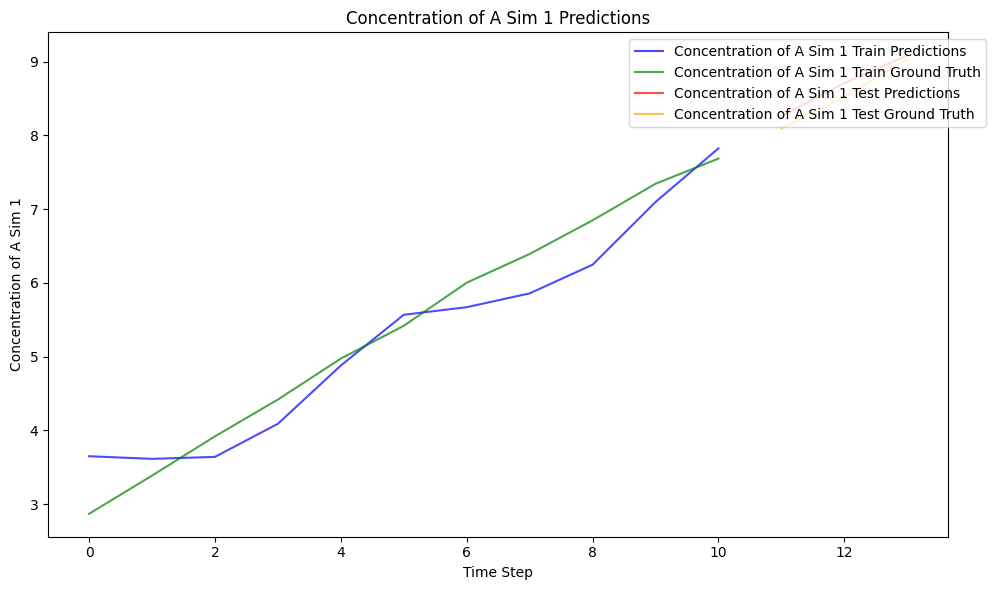

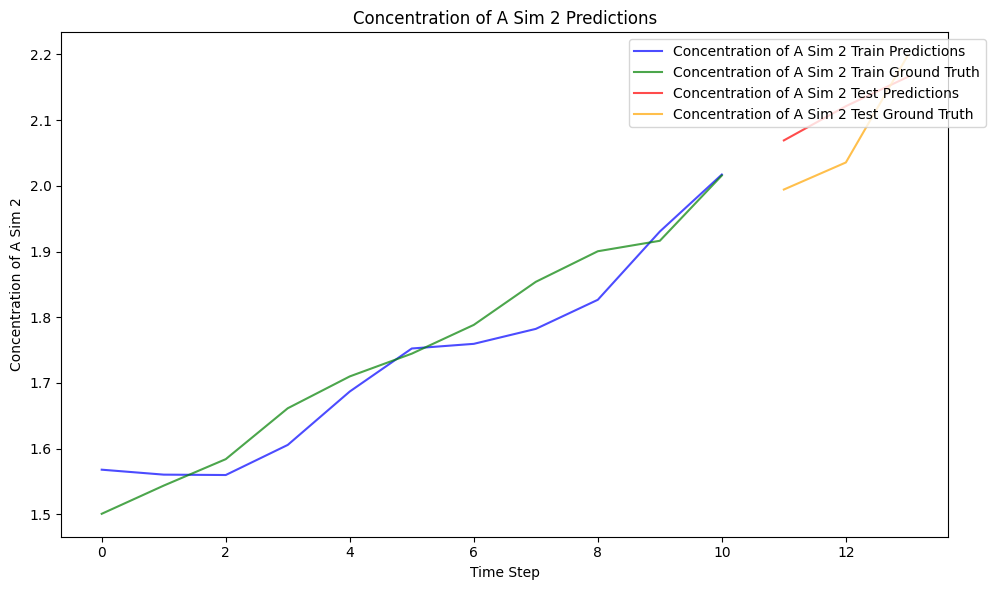

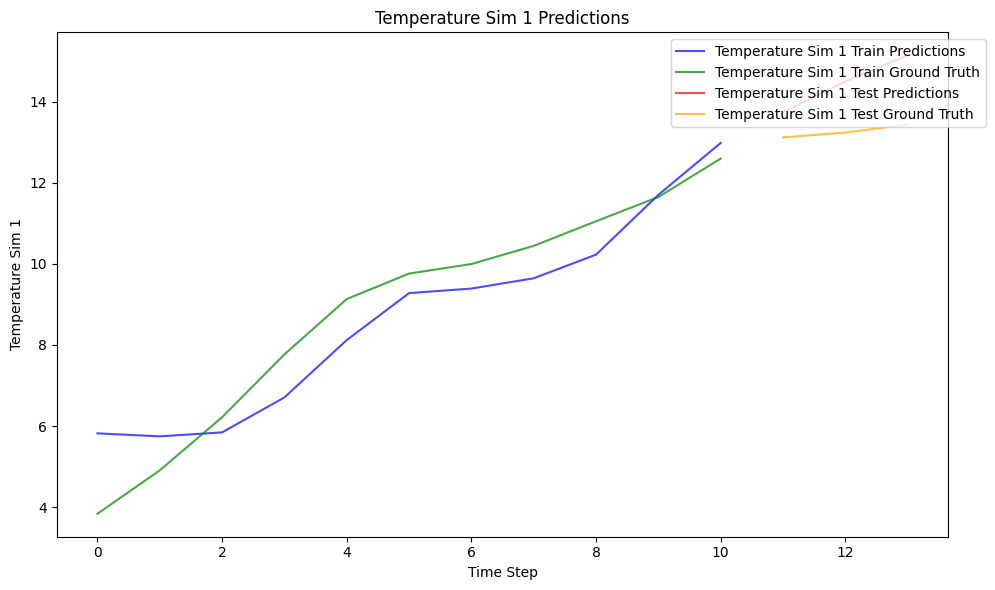

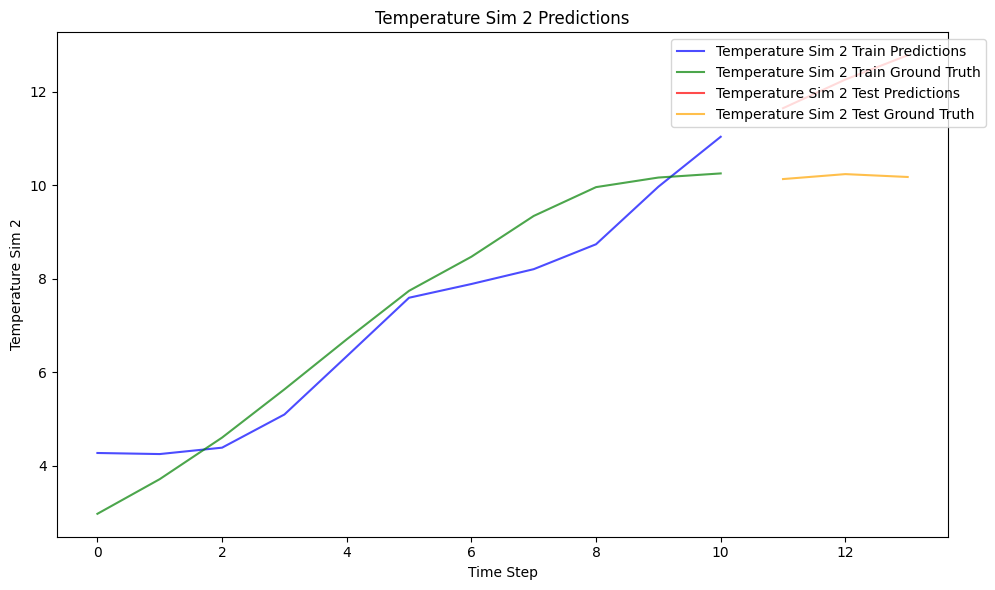

In [30]:
train_pred = model(X_train.to(training_config.device)).cpu().detach().numpy()
test_pred = model(X_test.to(training_config.device)).cpu().detach().numpy()

# Transform the predictions back to the original
train_pred, test_pred = scaler.inverse_transform(train_pred), scaler.inverse_transform(test_pred)
 
# Plot the optimised predictions of the model
visualiser.plot_predictions(train_pred, test_pred, y_train, y_test, feature_names, num_simulations=2)

Can also use a second simulation, a Photoproduction Bioprocess Reactor.

This has state variables:
$C_x$ , biomass concentration in g/L

$C_N$ , nitrate concentration in mg/L

$C_{qc}$ , phycocyanin concentration in mg/L

The control variables are:
$I$, light intensity in $\mu  mol  m^{-2}  s^{-1}$

$F_N$, nitrate flow rate in $ mg. L^{-1} h{-1} $

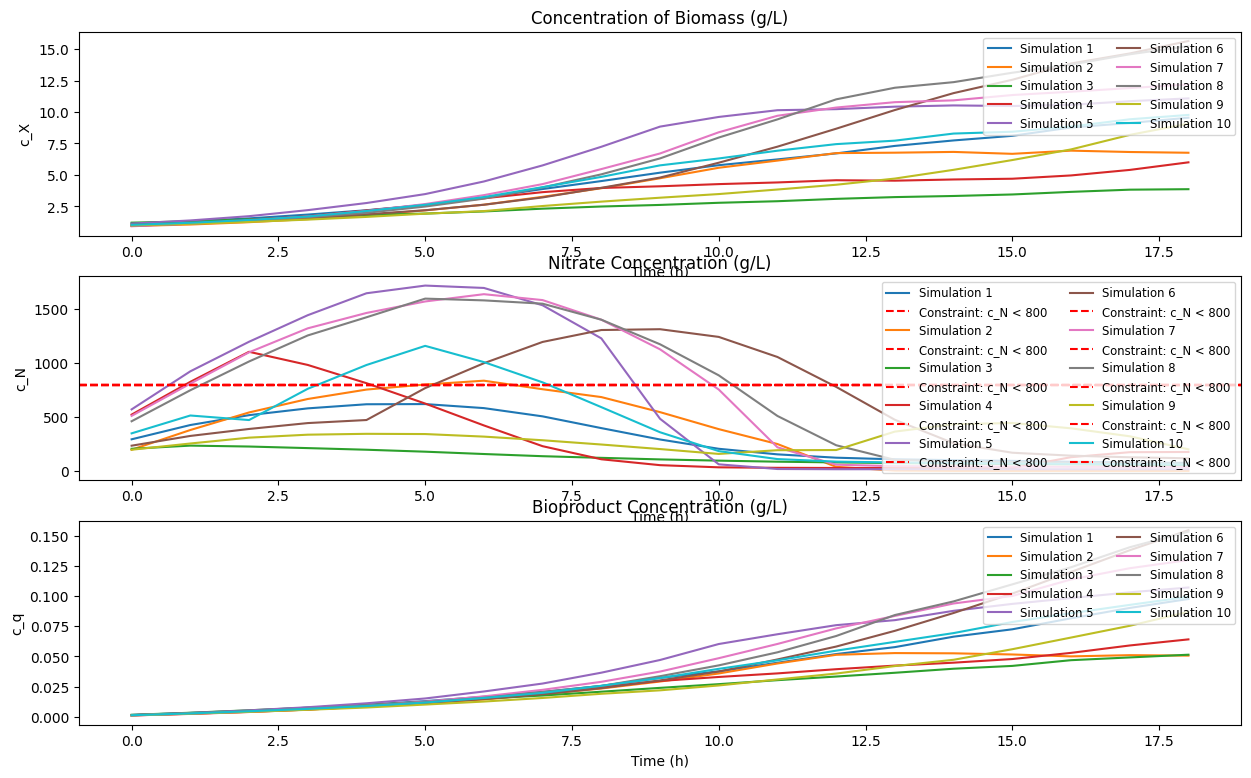

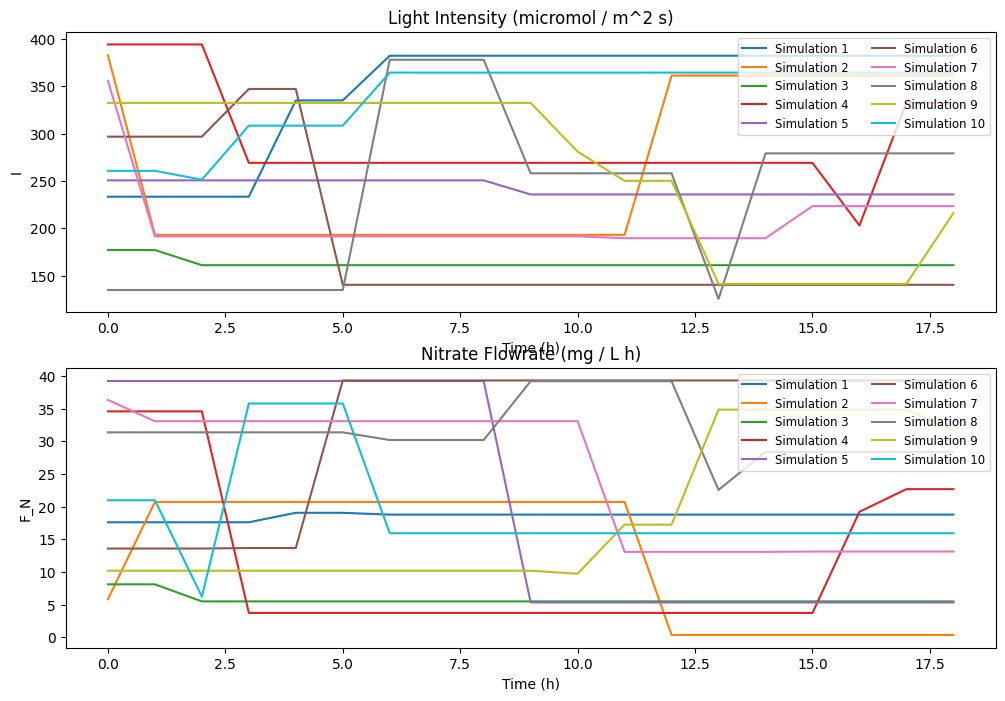

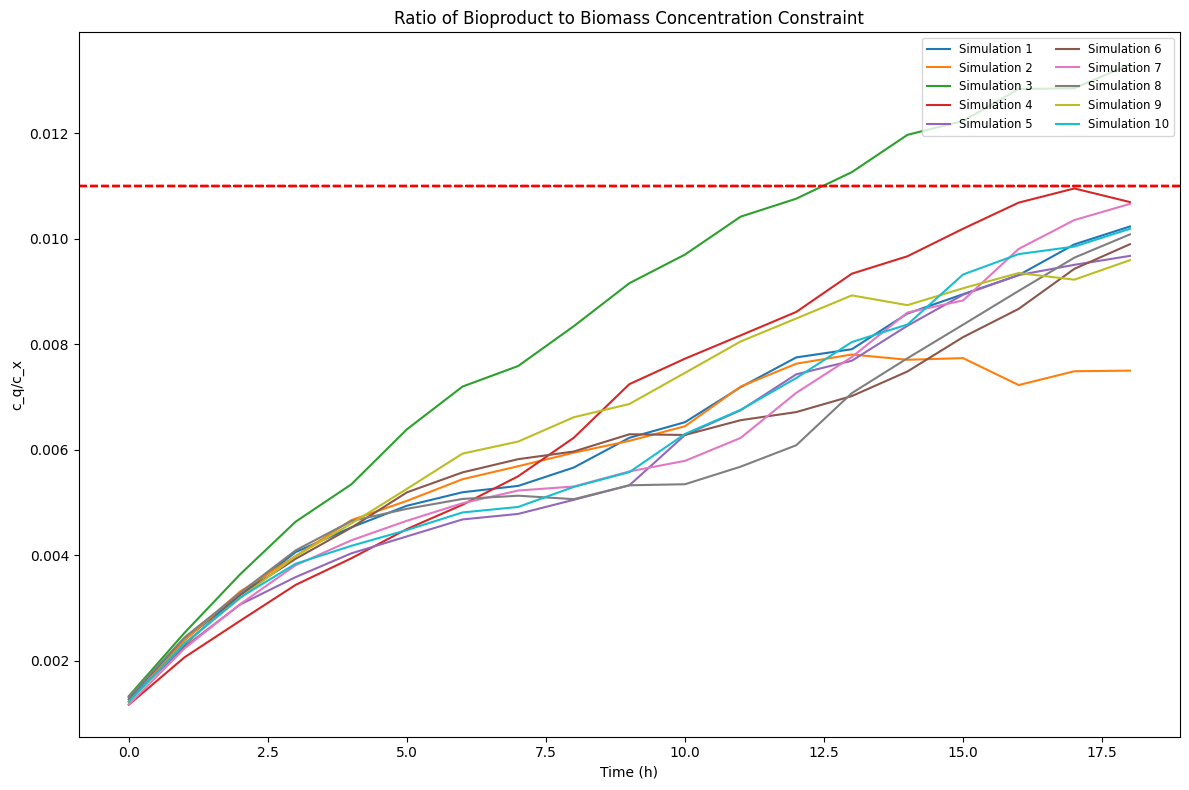

In [31]:
Bioprocess_Config = SimulationConfig(n_simulations=10, T = 20, tsim = 240) # Simulate the CSTR 10 times, with 5000 timesteps over 1000 second period

simulator = BioProcessSimulator(Bioprocess_Config)
simulation_results = simulator.run_multiple_simulations()

# Plot the output of the Simulation
simulator.plot_results(simulation_results)

In [32]:
converter = BioprocessConverter()
features, targets = converter.convert(simulation_results)

# Define a preliminary training configuration for the model
# Data processing uses an initial lookback region of 5 timesteps to predict 1 in the future 
# with an 80% train test split and a batch size of 4
training_config = TrainingConfig(
    batch_size = 4,
    num_epochs = 50,
    learning_rate = 0.001,
    time_step = 5,
    horizon = 1,
    weight_decay = 0.01,
    factor = 0.8,
    patience = 10,
    delta = 0.1,
    train_test_split = 0.8,
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
)

data_processor = DataProcessor(training_config)
(train_loader, test_loader, X_train, X_test, y_train, y_test) = data_processor.prepare_data(features, targets)

Epoch [10/50], Train Loss: 0.0378, Test Loss: 0.0670, Avg Loss: 0.0524
Epoch [20/50], Train Loss: 0.0149, Test Loss: 0.0262, Avg Loss: 0.0206
Epoch [30/50], Train Loss: 0.0216, Test Loss: 0.0309, Avg Loss: 0.0262
Epoch [40/50], Train Loss: 0.0258, Test Loss: 0.0302, Avg Loss: 0.0280
Epoch [50/50], Train Loss: 0.0222, Test Loss: 0.0277, Avg Loss: 0.0249


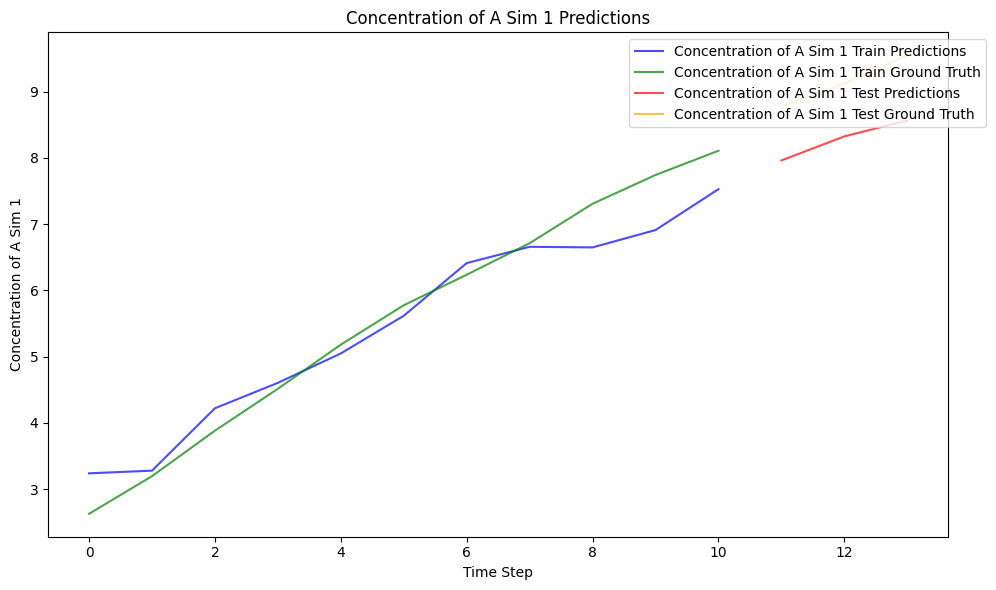

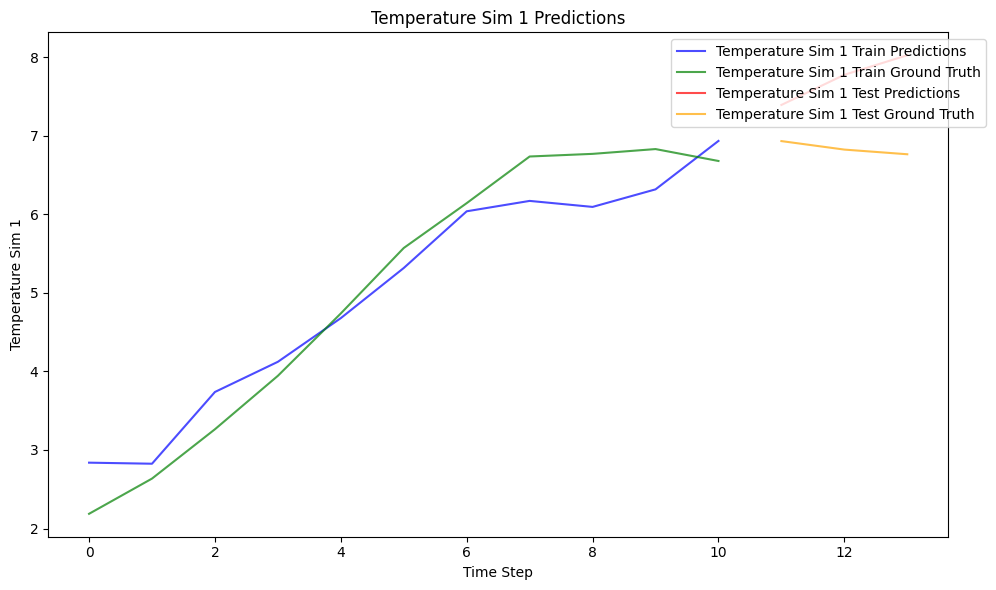

In [33]:
CNN_Config = CNNConfig(
    conv_channels = [16, 32],
    kernel_sizes = [5, 3],
    fc_dims = [101, 128],
    dropout = 0.1
    )

quantiles = [0.25, 0.5, 0.75]

model = StandardCNN(
    config = CNN_Config,
    input_dim = X_train.shape[2],
    output_dim = y_train.shape[1],
)

# Train the model
criterion = nn.MSELoss()
trainer = ModelTrainer(model, training_config)
model, history, avg_loss = trainer.train(train_loader, test_loader, criterion)

# Find the model predictions
model.eval()
with torch.no_grad():
    train_pred = model(X_train.to(training_config.device)).cpu().numpy()
    test_pred = model(X_test.to(training_config.device)).cpu().numpy()

# Transform the predictions back to the original
scaler = data_processor.target_scaler
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

# Invert the ground truth data
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)


# Plot the results of the model
feature_names = ['Concentration of A', 'Temperature']
visualiser = Visualizer()
# For simplicity we will plot the first simulation
visualiser.plot_predictions(train_pred, test_pred, y_train, y_test, feature_names, num_simulations=1)

### Quantifying Uncertainty in the Model Output

#### Monte Carlo Dropout
   - This is essentially a Bayesian Approximation, as this involves sampling with replacement and randomly setting the weights of the output of the model to 0
   - This is applied post training, and accounts for the aleatoric uncertainty of the model

In [34]:
CNN_Config = CNNConfig(
    conv_channels = [16, 32],
    kernel_sizes = [5, 3],
    fc_dims = [101, 128],
    dropout = 0.1
    )

model = MC_CNN(
    config = CNN_Config,
    input_dim = X_train.shape[2],
    output_dim = y_train.shape[1],
)

# Train the model
criterion = nn.MSELoss()
trainer = ModelTrainer(model, training_config)
model, history, avg_loss = trainer.train(train_loader, test_loader, criterion)

NameError: name 'MC_CNN' is not defined

In [ ]:
# Initialise the Monte Carlo Predictor
mc_predictor = MC_Prediction(model, CNN_Config, num_samples = 1000)
# Pass the test data through the model, with a Monte Carlo sample size of 100
mean_train_pred, var_train_pred = mc_predictor.predict(X_train)
mean_test_pred, var_test_pred = mc_predictor.predict(X_test)

In [ ]:
# Invert the training prediction
mean_train_pred, mean_test_pred = scaler.inverse_transform(mean_train_pred), scaler.inverse_transform(mean_test_pred)
var_train_pred, var_test_pred = scaler.inverse_transform(var_train_pred), scaler.inverse_transform(var_test_pred)

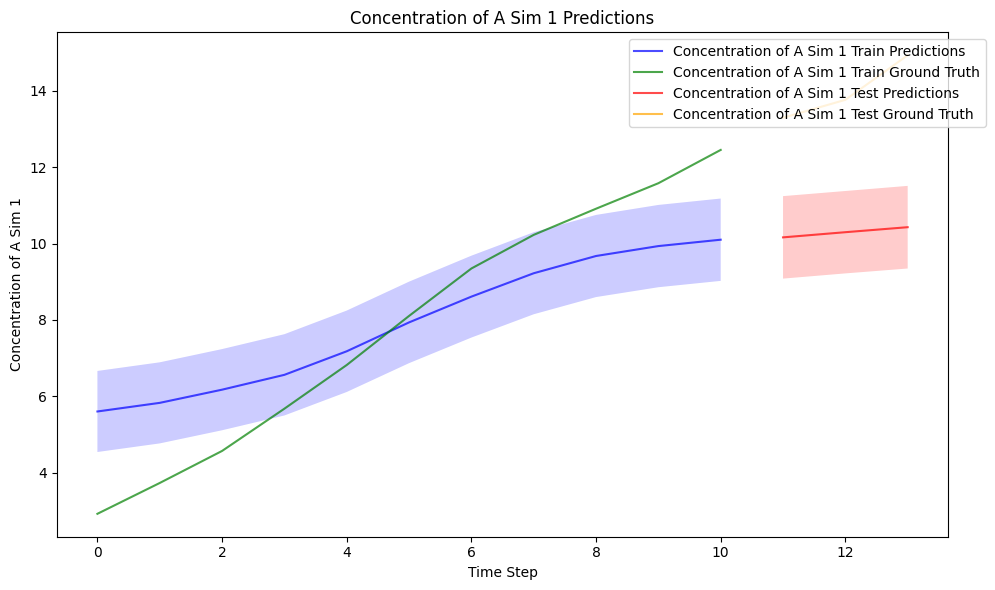

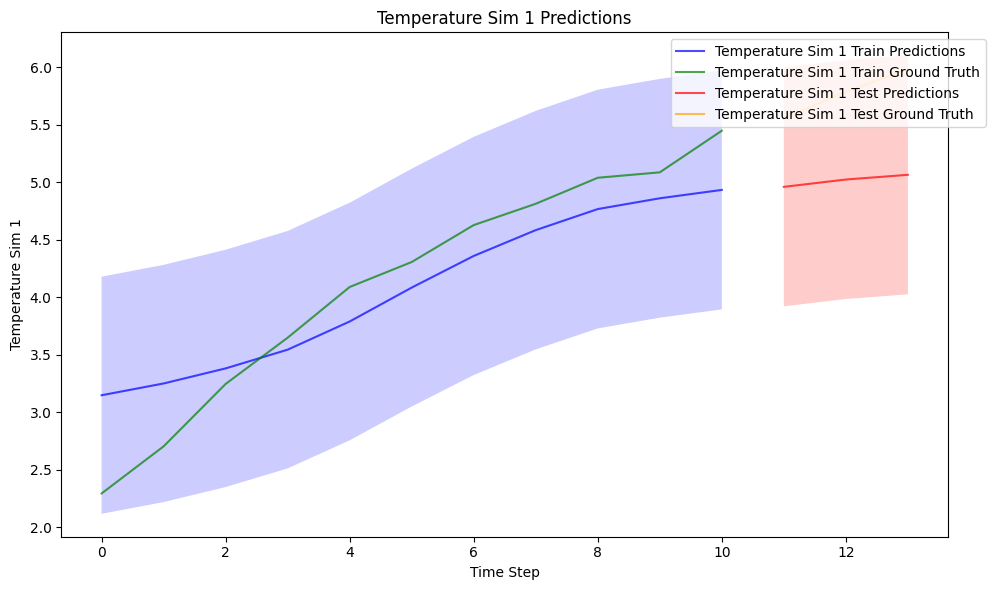

In [ ]:
# Visualise the output
visualiser.plot_predictions(mean_train_pred, mean_test_pred, y_train, y_test, feature_names, num_simulations=1, train_var = var_train_pred, test_var = var_test_pred)

#### Negative Log Likelihood Loss Function
- This uses a second projection layer from the output of the network to predict the log variance of the prediction
- The output can be used to find uncertainty bounds
- The negative log likelihood assumes the output variables are normally distributed

In [ ]:
CNN_Config = CNNConfig(
    hidden_dim = 64,
    num_layers=2,
    dropout = 0.2,
    bidirectional=False,
)

model = NLL_CNN(
    config = CNN_Config,
    input_dim = X_train.shape[2],
    output_dim = y_train.shape[1],
)

# Train the model
criterion = nn.GaussianNLLLoss()
trainer = ModelTrainer(model, training_config)
model, history, avg_loss = trainer.train(train_loader, test_loader, criterion)

Epoch [10/50], Train Loss: -0.0906, Test Loss: -0.0099, Avg Loss: -0.0503
Epoch [20/50], Train Loss: -0.8284, Test Loss: 0.4349, Avg Loss: -0.1968
Epoch [30/50], Train Loss: -1.2167, Test Loss: 0.3035, Avg Loss: -0.4566
Epoch [40/50], Train Loss: -1.7238, Test Loss: 1.9186, Avg Loss: 0.0974
Epoch [50/50], Train Loss: -2.1081, Test Loss: 4.8656, Avg Loss: 1.3787


In [ ]:
# The NLL CNN model outputs the mean and variance of the prediction
model.eval()
with torch.no_grad():
    train_pred, train_var = model(X_train.to(training_config.device))
    test_pred, test_var = model(X_test.to(training_config.device))
    
# Invert the predictions    
train_pred, test_pred = scaler.inverse_transform(train_pred.cpu().numpy()), scaler.inverse_transform(test_pred.cpu().numpy())
train_var, test_var = scaler.inverse_transform(train_var.cpu().numpy()), scaler.inverse_transform(test_var.cpu().numpy())

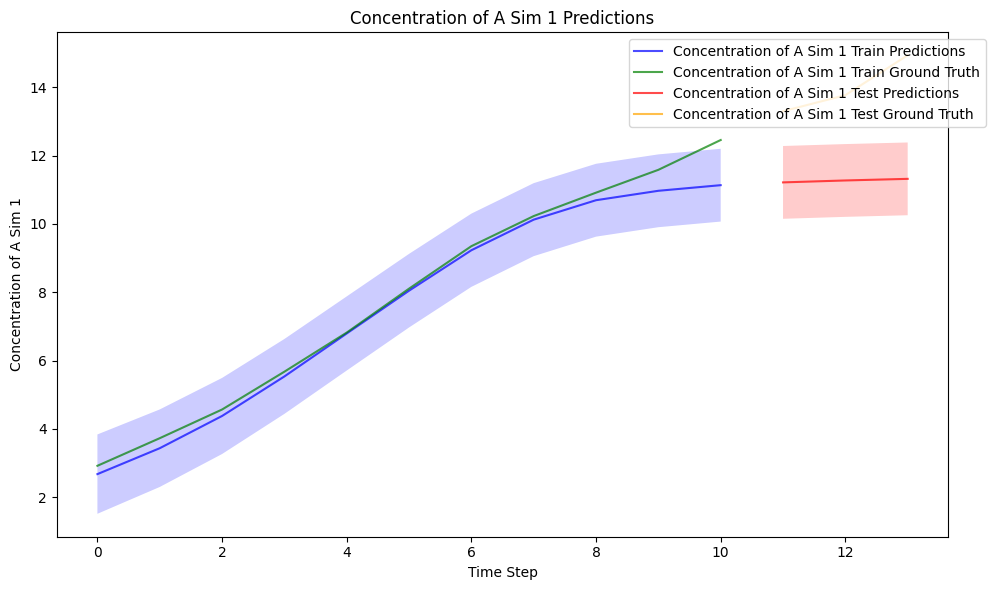

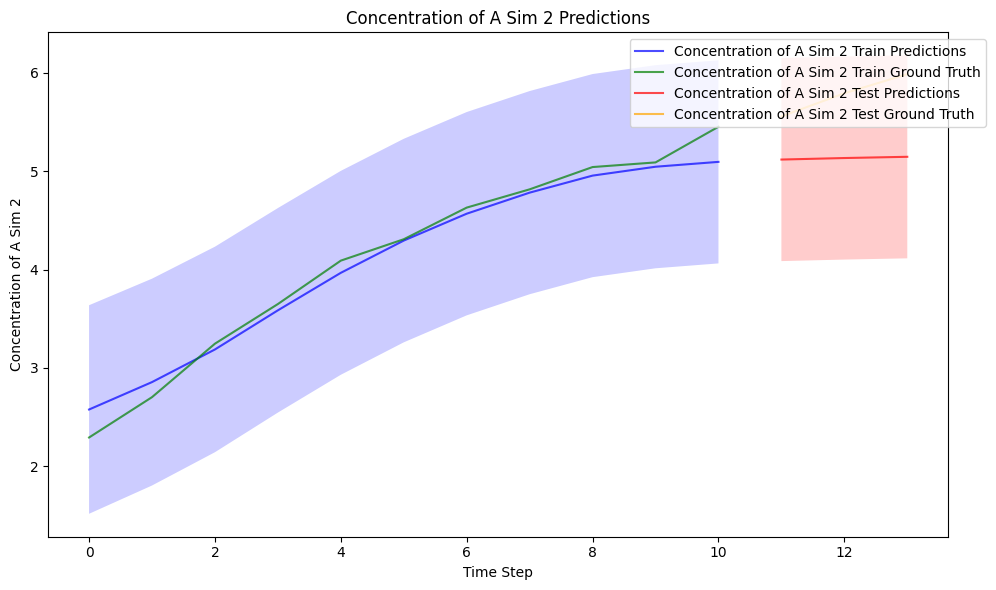

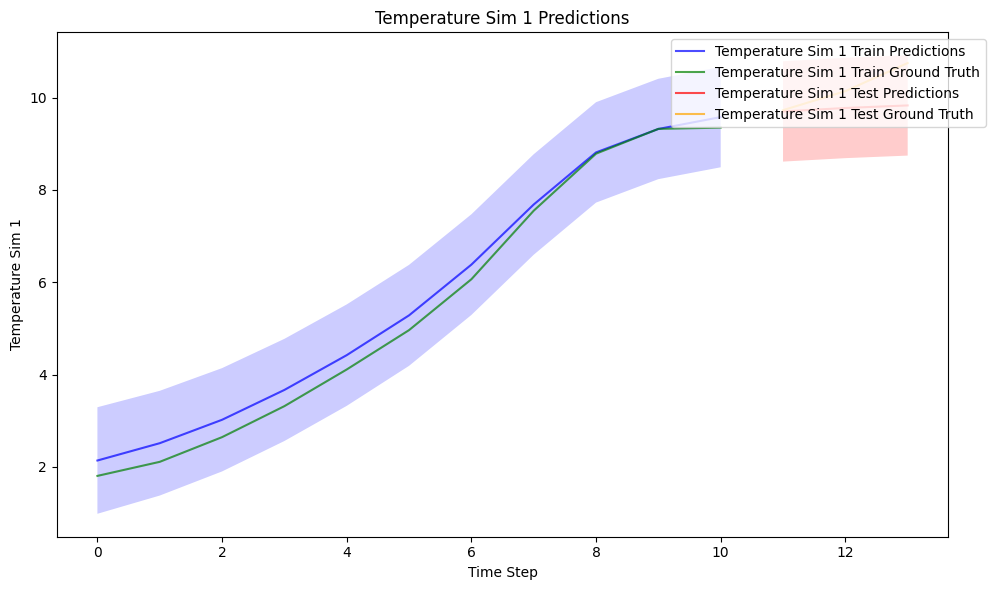

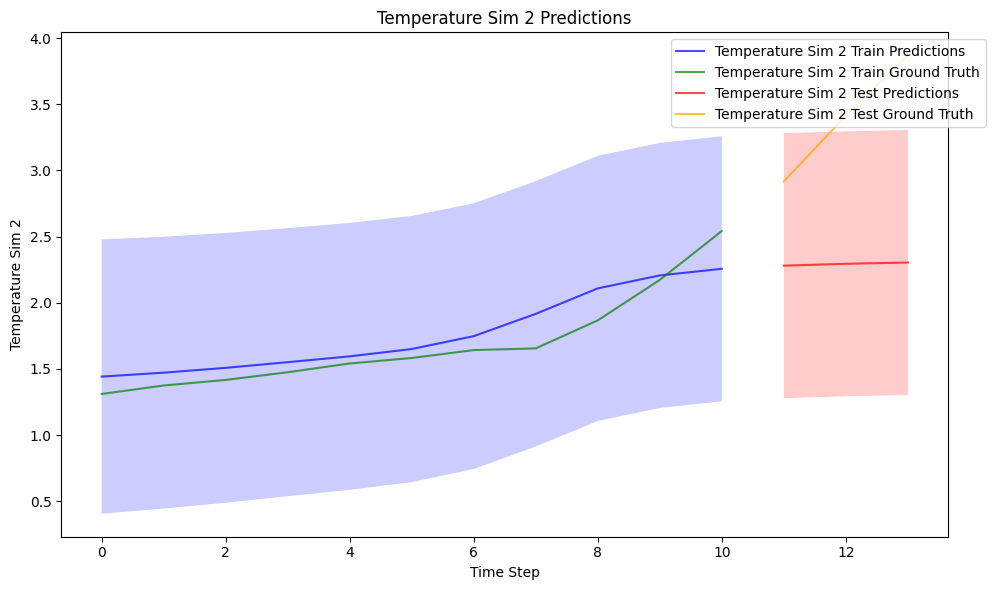

In [ ]:
visualiser.plot_predictions(train_pred, test_pred, y_train, y_test, feature_names, num_simulations=2, train_var = train_var, test_var = test_var)

#### Quantile Regression
- Quantile Regression uses a pinball loss function to account for the 'quantile' the each prediction should lie above
- The median quantile reverts back to the MSE Loss Function
- Distribution free method

In [ ]:
CNN_Config = CNNConfig(
    hidden_dim = 64,
    num_layers=2,
    dropout = 0.2,
    bidirectional=False,
)

# Train the model on the 25th, 50th and 75th quantiles
quantiles = [0.25, 0.5, 0.75]

model = QuantileCNN(
    config = CNN_Config,
    input_dim = X_train.shape[2],
    output_dim = y_train.shape[1],
    quantiles = quantiles
)

# Train the model
criterion = QuantileLoss(quantiles)
trainer = ModelTrainer(model, training_config)
model, history, avg_loss = trainer.train(train_loader, test_loader, criterion)

Epoch [10/50], Train Loss: 0.1826, Test Loss: 0.2916, Avg Loss: 0.2371
Epoch [20/50], Train Loss: 0.1228, Test Loss: 0.2203, Avg Loss: 0.1715
Epoch [30/50], Train Loss: 0.0946, Test Loss: 0.1743, Avg Loss: 0.1345
Epoch [40/50], Train Loss: 0.0826, Test Loss: 0.1440, Avg Loss: 0.1133
Epoch [50/50], Train Loss: 0.0758, Test Loss: 0.1171, Avg Loss: 0.0964


In [ ]:
# Get the output of the model

model.eval()
with torch.no_grad():
    train_pred = model(X_train.to(training_config.device)).cpu().numpy()
    test_pred = model(X_test.to(training_config.device)).cpu().numpy()

# Invert the output of the model
inverse_transformer = QuantileTransform(quantiles, scaler)
train_pred = inverse_transformer.inverse_transform(train_pred)
test_pred = inverse_transformer.inverse_transform(test_pred)

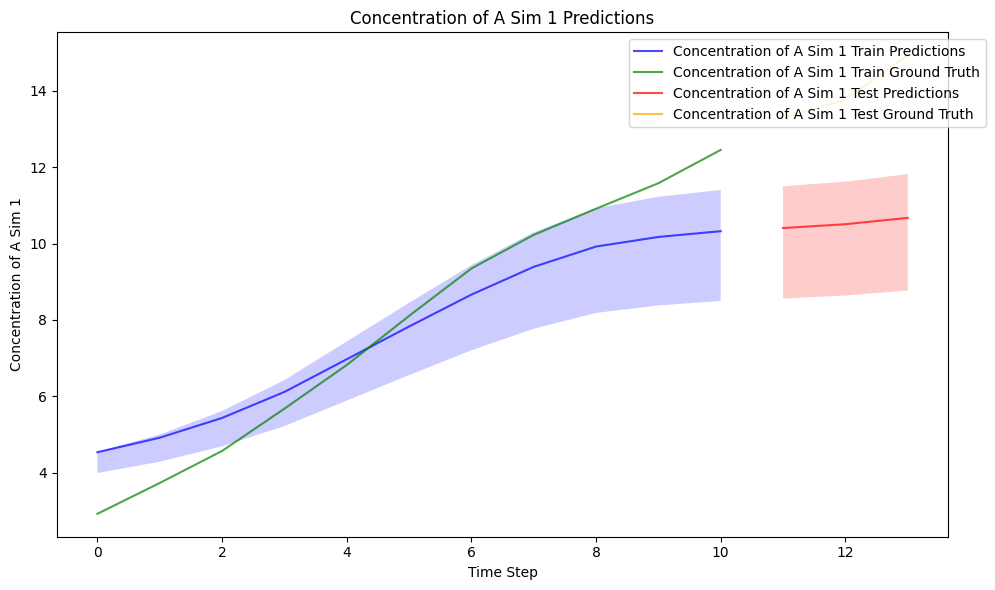

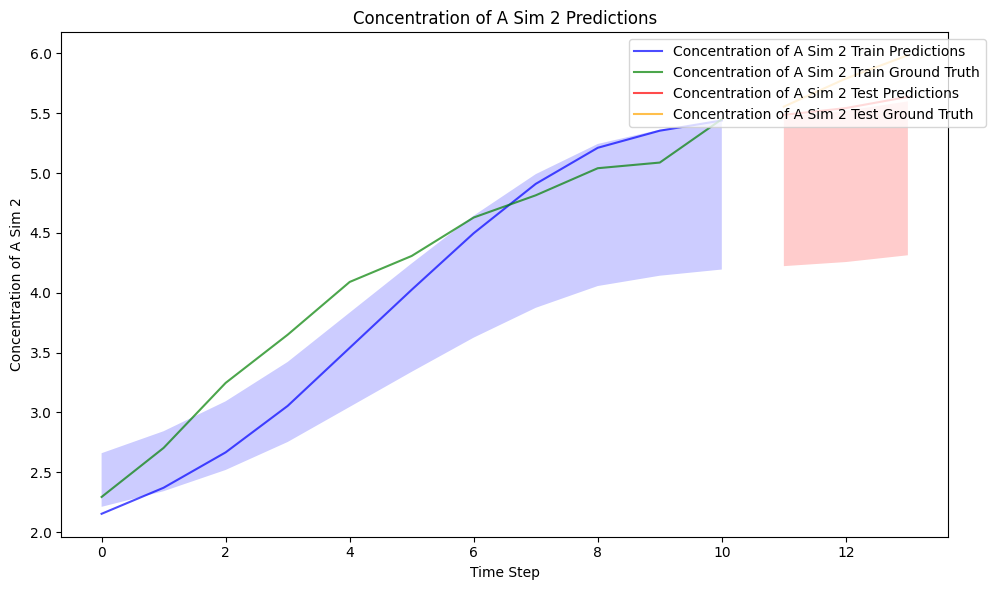

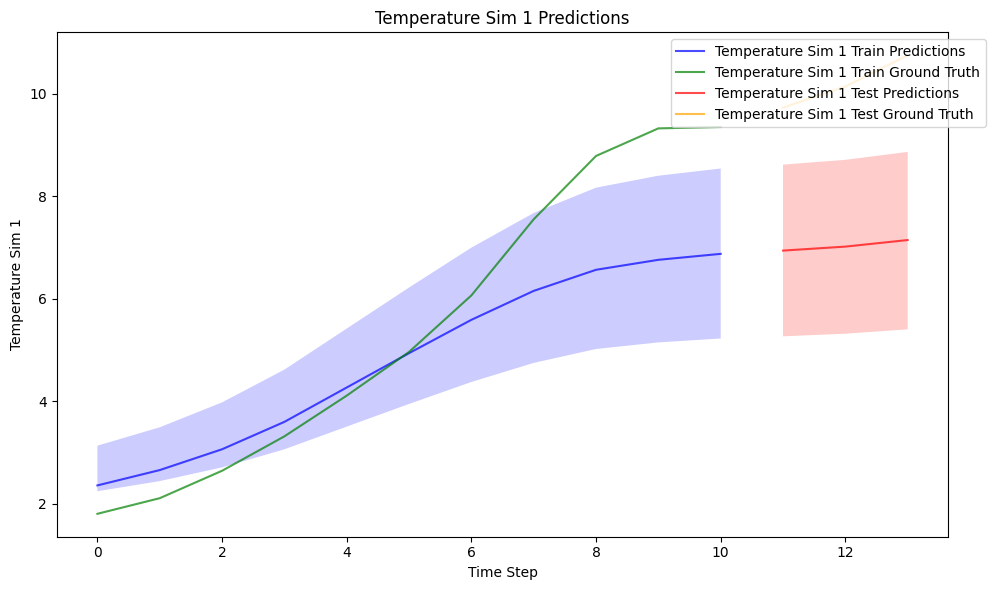

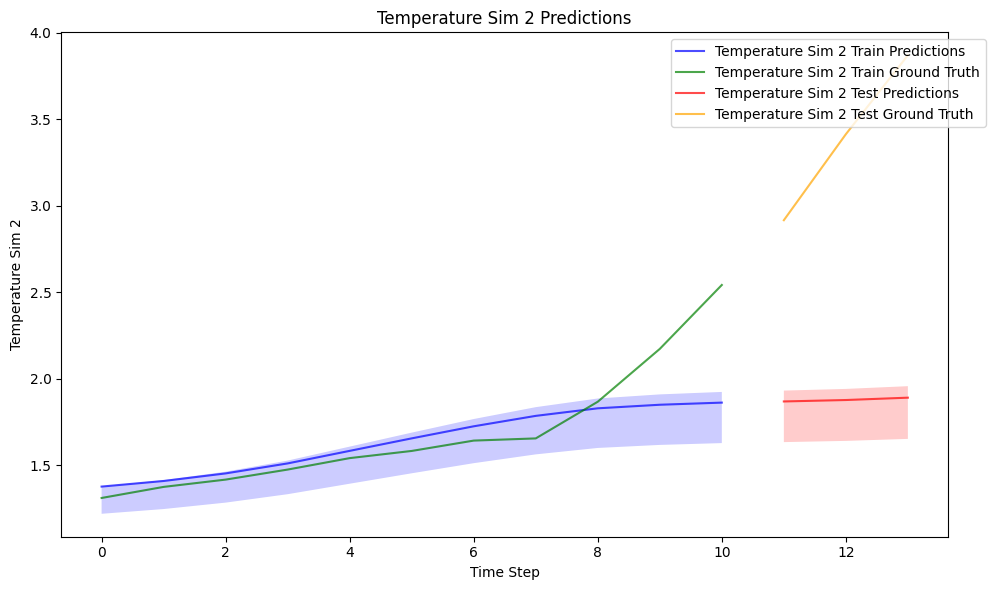

In [ ]:
visualiser.plot_predictions(train_pred, test_pred, y_train, y_test, feature_names, num_simulations=2)

Quantile regression offers no guarantees that a certain quantile will contain a certain amount of the data-points, hence is tough to provide an exact confidence level.
Conformal prediction uses the test set to calculate the residuals, assign a score and then after sorting the residuals, can calibrate a distribution free confidence bound.

[[1.32435054e+00 1.43048403e-01 1.11439319e+00 5.27634554e-01
  5.44112084e-01 2.69837668e-01 1.16866159e+00 2.39682580e-01
  1.10838332e+00 4.98558359e-01 7.19282094e+01 1.67155624e+01
  2.75387655e+02 1.62915255e+02 4.83394592e+01 7.69805311e+01
  8.68034600e+01 7.74778325e+01 6.73619362e+01 2.27289349e+01
  2.61427593e-02 6.55329737e-03 1.48059596e-02 3.16934226e-03
  1.38745979e-02 7.39576258e-03 2.36269235e-02 9.84734160e-03
  2.70695073e-02 1.24019947e-02]
 [1.50634087e+00 2.36134819e-01 1.27969793e+00 7.71823950e-01
  6.52771665e-01 3.20142431e-01 1.58756872e+00 2.50947618e-01
  1.37456776e+00 6.59509976e-01 7.61688732e+01 1.78787015e+01
  2.35536942e+02 1.30239104e+02 2.64067004e+01 7.73801383e+01
  8.94743929e+01 7.80396030e+01 7.17724963e+01 2.55288294e+01
  3.36064770e-02 8.40641601e-03 1.88719669e-02 5.13683293e-03
  1.74216416e-02 8.24429337e-03 3.15260698e-02 1.21410531e-02
  3.46482493e-02 1.54570453e-02]
 [2.00228469e+00 2.93420708e-01 1.51717969e+00 9.92775646e-01
  1.

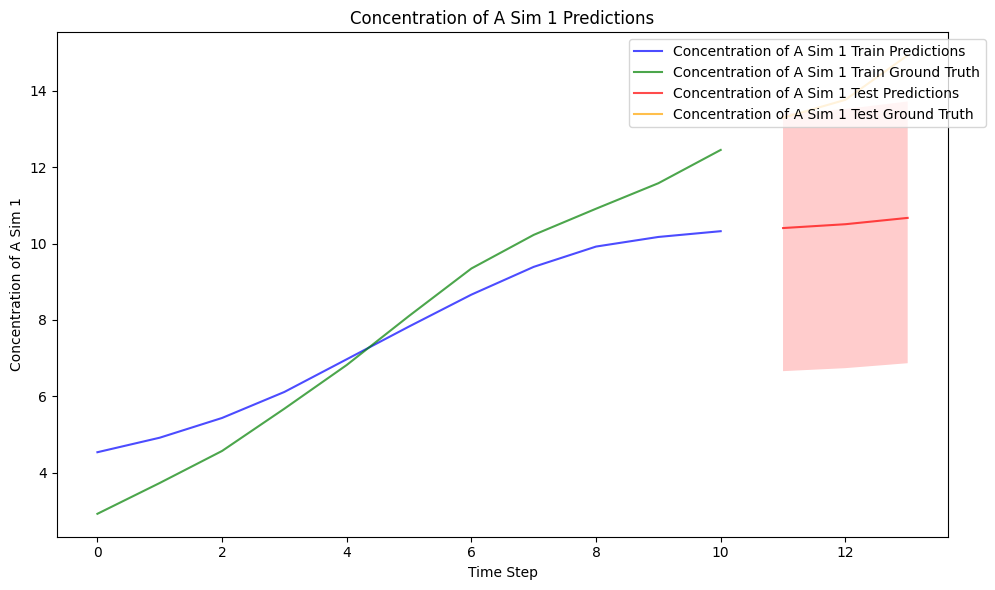

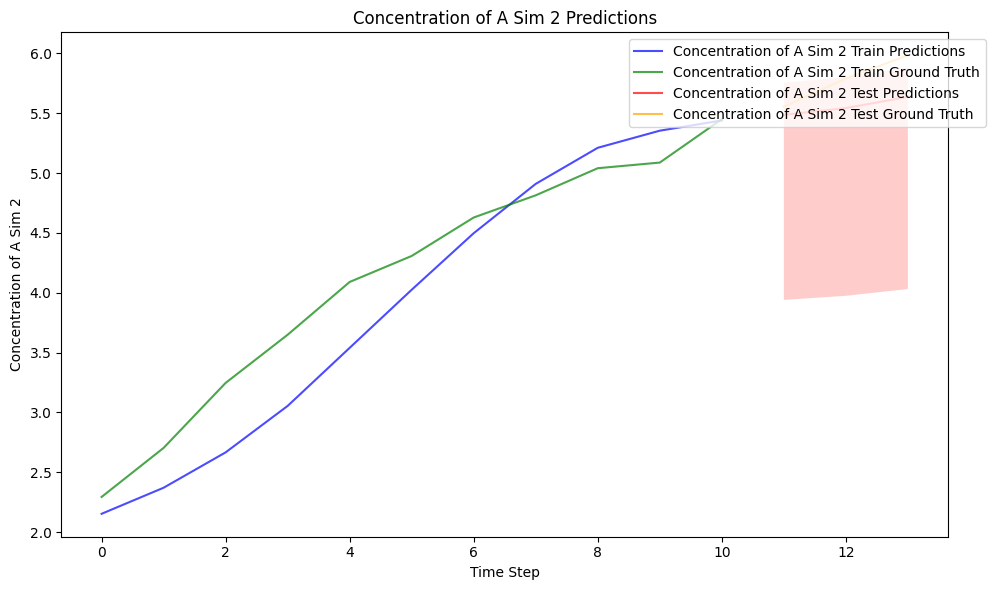

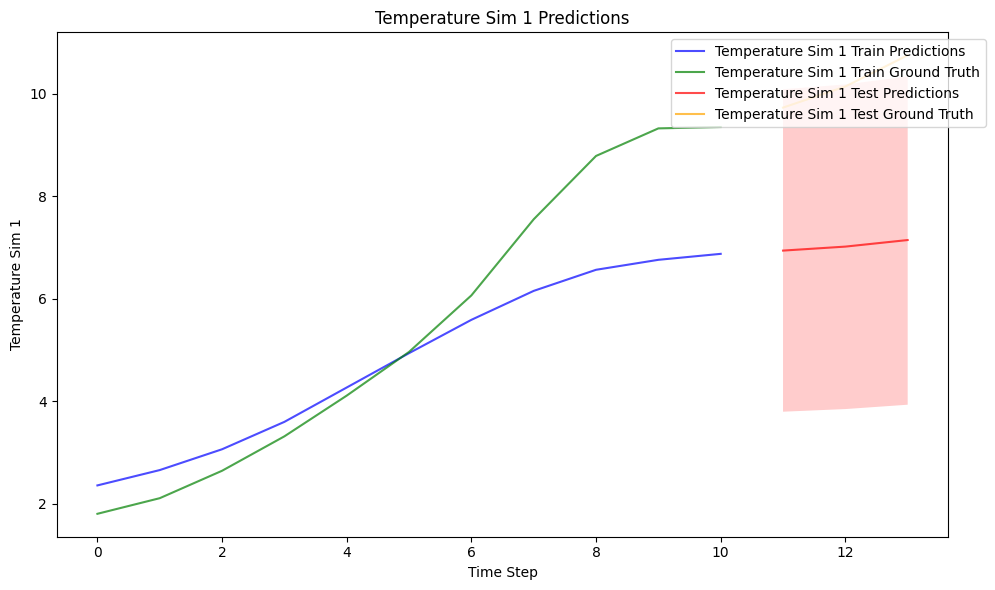

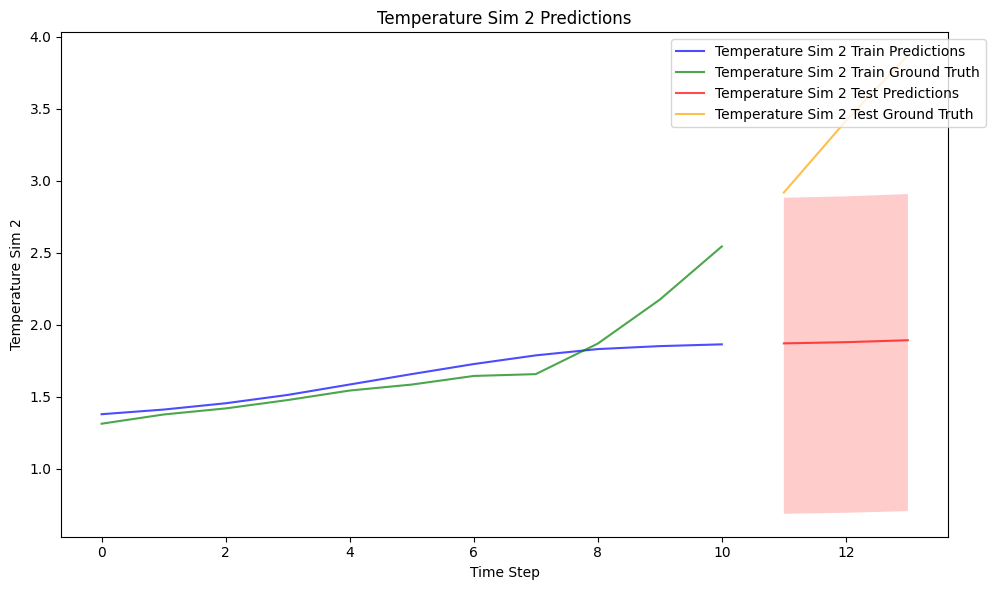

In [ ]:
conformal = ConformalQuantile(model, inverse_transformer, alpha = 0.10) # Alpha is the parameter to bound the confidence interval - e.g. 0.1 = 90% confidence
conformal.fit_calibrate(X_test, y_test, method='absolute')
results = conformal.predict(X_test, y_test, method = 'absolute') # Calculates the absolute residuals 

# Results is a dictionary containing the 90% confidence bounds, and also the equivalent quantile corresponding to the desired confidence level
# e.g. the 90% confidence could be found between the 25th and 75th quantile

visualiser.plot_conformal(train_pred[0.5], test_pred[0.5], y_train, y_test, results, feature_names, num_simulations=2)